In this iPython notebook, we will featurize MOR ligand binding simulation by pairwise distances between the ligand and different receptor residues. We will then perform tICA and prospectively build an MSM. 

In [1]:
from PDB_Order_Fixer import PDB_Order_Fixer
import mdtraj as md
import os
import numpy as np
import h5py

import datetime
import glob
import copy
from functools import partial 
import operator
import time

import random 
import subprocess
from subprocess import Popen
import sys
from io_functions import *
from custom_clusterer import *
from custom_tica import *
from custom_featurizer import *
from pdb_editing import *
from analysis import *
from io_functions import *
#from topology_fixing import *
from subsampling import *
from conversions import *
from custom_msm import *
from grids import *
from docking_analysis import *

In [2]:
from detect_intermediates import *
from interpret_tICs import *

we are operating on biox3


/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
from b2ar_feature_types import *
from get_variable_names import *
from b2ar_tica_config import *
from residue import Residue, Atom

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt

#set_palette('Set1', n_colors=15, desat=None)

In [5]:
ori_feature_name = copy.deepcopy(feature_name)

In [6]:
#schemes = ["closest-heavy", "CA"]
#feature_name = "%s-CA" %ori_feature_name

In [7]:
rho = 0.01
rho_string = "_rho0pt01"

In [8]:
(active_ref_dir, inactive_ref_dir, simulation_ref_dir, scripts_dir,
          ligand_dir, agonist_dir, inverse_agonist_dir, biased_agonist_dir, ref_receptors_dir, whole_trajectory_pnas,
          sasa_file) = get_base_files(base)

tica_dir = get_tica_dir(base, is_sparse, lag_time, n_components, feature_name, 
                                 wolf_string, shrinkage_string, rho_string)
ori_tica_dir = copy.deepcopy(tica_dir)
features_dir = get_features_dir(base, feature_name)

landmarks_dir = get_landmarks_dir(tica_dir)
analysis_dir = get_analysis_dir(tica_dir, n_clusters, sampling_method)
gmm_dir = get_gmm_dir(tica_dir)
rf_dirdir = get_rf_dir(tica_dir)


ref_tica_dir, ref_tica_coords = get_ref_tica_dirs(tica_dir)

graph_file = get_graph_file(tica_dir, msm_lag_time, n_clusters)

pnas_titles =  ["tm6_tm3_dist", "rmsd_npxxy_inactive", "rmsd_npxxy_active", "rmsd_connector_inactive", "rmsd_connector_active"]
pnas_features_dir = analysis_dir


(clusterer_dir, msm_model_dir, macrostate_dir, features_known, model_dir, projected_features_dir,
         projection_operator_dir, ktica_fit_model_filename, ktica_projected_data_filename, nystroem_data_filename,
         mutual_information_csv, pearson_csv) = get_tica_files(base, tica_dir, n_clusters, msm_lag_time, n_macrostates)

(standardized_features_dir, feature_residues_csv, feature_residues_pkl,
          contact_csv, ref_features_dir) = get_feature_files(features_dir)

(kmeans_csv, tica_coords_csv, features_csv, active_rmsd_dir, inactive_rmsd_dir, active_pnas_dir, inactive_pnas_joined, active_pnas_joined,
        clusters_map_file, ktica_clusters_map_file, analysis_file, combined_file, docking_summary, docking_joined, docking_z_scores_csv,
        aggregate_docking, aggregate_docking_joined, docking_pnas_joined, aggregate_docking_pnas, aggregate_docking_pnas_joined, docking_multiple_ligands,
        docking_distances_file, docking_pdf, mmgbsa_docking_distances, pnas_coords, mmgbsa_dir, mmgbsa_csv, mmgbsa_pdf, aggregate_mmgbsa,
        aggregate_mmgbsa_joined, aggregate_mmgbsa_pnas_joined, mmgbsa_z_scores_csv, active_clusters_csv, intermediate_clusters_csv,
        inactive_clusters_csv, pnas_clusters_averages, tica_clusters_averages, tica_classes_csv, tica_samples_csv, subgraph_save_base,
        degree_save_base, degree_map_csv, degree_z_map_csv, aggregate_docking_pnas_degree_z_joined, tic_residue_csv, feature_coefs_csv,
        duplicated_feature_coefs_csv) = get_analysis_files(analysis_dir, n_clusters, tica_dir, tica_dir, sampling_method, n_samples, precision,
                                                           msm_lag_time)

(inactive_pnas_distances_dir, active_pnas_distances_dir, active_pnas_all_distances_dir,
          inactive_pnas_distances_new_csv, active_pnas_distances_new_csv, active_pnas_joined, active_pnas_means, pnas_coords_dir,
          pnas_coords_csv, pnas_all_coords_csv, pnas_coords_hexbin_dir, pnas_coords_co_crystallized_docking_dir,
          pnas_coords_active_colors_dir, user_defined_features_file, reaction_coordinates_trajs_file) = get_pnas_files(whole_trajectory_pnas, pnas_features_dir)

features_dir = get_features_dir(base, feature_name)



graph_file = get_graph_file(tica_dir, msm_lag_time, n_clusters)
(scripts_dir, pymol_fixpdb_dir) = get_script_dir(scripts_dir)
(save_dir, reimaged_dir, mae_dir, combined_reimaged_dir, grid_dir, docking_dir) = get_docking_dirs(tica_dir, n_clusters, n_components, n_samples, sampling_method, precision)


/home/enf/b2ar_analysis/featuresall_residues_2rh1_3sn6_under_cutoff6A
/home/enf/b2ar_analysis/featuresall_residues_2rh1_3sn6_under_cutoff6A


In [9]:
tica_dir

'/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01'

In [10]:
cutoff

0.66

In [11]:
schemes

NameError: name 'schemes' is not defined

In [ ]:
contact_residues

In [ ]:
if not os.path.exists(features_dir): os.makedirs(features_dir)
import custom_featurizer
reload(custom_featurizer)
from custom_featurizer import *
featurize_contacts_custom(traj_dir, features_dir = features_dir, 
                          traj_ext = traj_ext, contact_residue_pairs_file = feature_residues_pkl, 
                          structures = [active_ref_dir, inactive_ref_dir], dihedral_residues =  [], 
                          dihedral_types = ["phi", "psi", "chi1", "chi2"], 
                          contact_residues =  contact_residues, residues_map = None, 
                          contact_cutoff = cutoff, parallel = False, 
                          exacycle = exacycle, load_from_file=False, schemes=schemes)


In [ ]:
fit_and_transform(features_directory = features_dir, model_dir = tica_dir, stride=5, lag_time = lag_time, n_components = n_components, sparse = sparse, wolf = wolf, rho = rho, shrinkage = shrinkage, parallel=True, traj_ext = traj_ext, normalize=True)

In [8]:
tica_object = verboseload(projection_operator_dir)
print(tica_object.timescales_)

loading "/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/phi_psi_chi2_allprot_tica_coords.h5"...
[ 608.76369352  342.82218117  245.50411087  215.63066628  154.69677355
  155.50637752  129.76331383  104.55745741  105.81972363  128.19281613
   98.09798731   77.75059767   72.03939041   63.51776034   65.46962409
   56.51628841   56.55764827   70.05206467   62.57206504   45.93474676
   46.11822305   41.0391746    44.00544067   37.35108      38.67501459]


In [59]:
tic_components_dir = tica_dir
important_contact_features = interpret_tIC_components(projection_operator_dir, tic_components_dir, feature_residues_pkl, n_tica_components=n_components, percentile=95)

loading "/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A-CA_regularization_wolf_autoShrinkage_rho0pt01/phi_psi_chi2_allprot_tica_coords.h5"...
Interpreting tIC 1
feature_importances_df.shape
(4, 7)
residue_importances_df.shape
(7, 3)
          feature_name      res_i      res_j  resid_i  resid_j  importance  \
3  Phe104_Ca-Gln170_Ca  Phe104_Ca  Gln170_Ca      104      170    0.295031   
1         Asp79-Tyr326      Asp79     Tyr326       79      326    0.188006   
0         Asp79-Asn318      Asp79     Asn318       79      318    0.173521   
2   Gly50_Ca-Pro323_Ca   Gly50_Ca  Pro323_Ca       50      323    0.169860   

                  feature  
3  [PHE104_CA, GLN170_CA]  
1         [ASP79, TYR326]  
0         [ASP79, ASN318]  
2   [GLY50_CA, PRO323_CA]  
             residue  importance  resid
Gln170_Ca  Gln170_Ca    0.295031    170
Phe104_Ca  Phe104_Ca    0.295031    104
Tyr326        Tyr326    0.188006    326
Asp79          Asp79    0.187281

In [21]:
tica_coords = verboseload(projected_features_dir)
pnas_coords = verboseload(pnas_coords_dir)
for pnas_coord in pnas_coords: pnas_coord[:,0]*=7.14
tica_names = ["tIC.%d" %i for i in range(1,n_components+1)]
pnas_names = ["tm6_tm3_dist", "rmsd_npxxy_inactive", "rmsd_npxxy_active", "rmsd_connector_inactive", "rmsd_connector_active"]

loading "/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/phi_psi_chi2_allprot_projected.h5"...
loading "/home/enf/b2ar_analysis/all_pnas_features/pnas_coords.h5"...


In [16]:
import plots
reload(plots)
from plots import *
plot_histograms(projected_features_dir, analysis_dir, "tICA histogram", titles=["tIC.%d" %i for i in range(1,n_components+1)])

loading /home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/phi_psi_chi2_allprot_projected.h5
loading "/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/phi_psi_chi2_allprot_projected.h5"...
Computed 1D KDE
Computed 1D KDE
Computed 1D KDE
Computed 1D KDE
Computed 1D KDE
Computed 1D KDE
Computed 1D KDE
Computed 1D KDE
Computed 1D KDE
Computed 1D KDE
Computed 1D KDE
Computed 1D KDE
Computed 1D KDEComputed 1D KDEComputed 1D KDEComputed 1D KDEComputed 1D KDEComputed 1D KDEComputed 1D KDEComputed 1D KDEComputed 1D KDEComputed 1D KDEComputed 1D KDEComputed 1D KDE











Computed 1D KDE


In [10]:
def calculate_cluster_averages_per_feature(clusterer, features):
  n_clusters = clusterer.n_clusters 
  concatenated_clusters = np.concatenate(clusterer.labels_)
  concatenated_features = np.concatenate(features)
  cluster_averages = np.zeros((n_clusters, concatenated_features.shape[1]))
  for i in range(0, n_clusters):
    rows = np.where(concatenated_clusters == i)[0]
    means = np.mean(concatenated_features[rows,:], axis=0)
    cluster_averages[i,:] = means
  return cluster_averages

In [11]:
clusterer = verboseload(clusterer_dir)
cluster_averages = calculate_cluster_averages_per_feature(clusterer, pnas_coords)


loading "/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/clusterer_1000clusters.h5"...


ValueError: zero-dimensional arrays cannot be concatenated

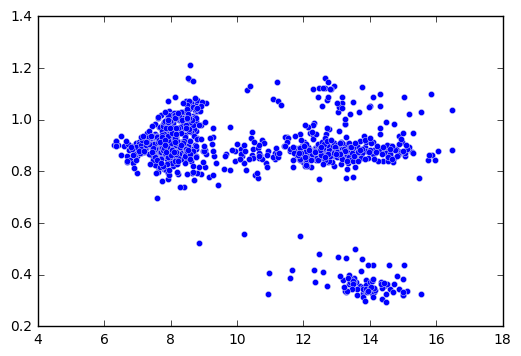

In [21]:
plt.scatter(cluster_averages[:,0], cluster_averages[:,2])

In [22]:
cluster_averages = pd.DataFrame(cluster_averages, columns=pnas_names)
active_clusters = cluster_averages.loc[(cluster_averages["rmsd_npxxy_active"] < 0.5) & (cluster_averages["tm6_tm3_dist"] > 12.) & (cluster_averages["tm6_tm3_dist"] < 15.)]
inactive_clusters = cluster_averages.loc[(cluster_averages["rmsd_npxxy_active"] > 0.5) & (cluster_averages["tm6_tm3_dist"] <10.)]

In [23]:
active_clusters

,tm6_tm3_dist,rmsd_npxxy_inactive,rmsd_npxxy_active,rmsd_connector_inactive,rmsd_connector_active
6,14.070836,1.018938,0.377357,0.685398,1.209663
15,13.697493,1.053278,0.356238,1.727751,0.842566
22,14.426732,1.046531,0.356615,1.158779,1.022419
35,12.320419,1.142434,0.416908,2.295924,1.707692
73,14.335858,1.073100,0.372462,2.368629,1.593167
78,13.873279,1.179568,0.377985,1.833994,1.236380
89,12.477614,0.953105,0.479240,1.466491,0.579541
106,13.805037,1.054689,0.331172,1.767875,1.168438
109,13.743991,0.973036,0.416502,1.994921,1.273357
125,14.368614,1.102396,0.307151,2.281881,1.515999


In [61]:
import plots
reload(plots)
from plots import *

In [ ]:
plot_data_vs_data(np.concatenate(tica_coords), np.concatenate(pnas_coords), tica_names, pnas_names, analysis_dir)

In [ ]:
analysis_dir

In [ ]:
plot_columns(tica_dir, projected_features_dir, titles = ["tIC%d" %j for j in range(1,11)], tICA = True, scale = 1.0, refcoords_file = None)

In [ ]:
get_ligands(agonist_dir)

In [ ]:
get_ligands(biased_agonist_dir)

In [ ]:
docking_multiple_ligands

In [289]:
from ipyparallel import Client
rc = Client()
print(len(rc.ids))
dview = rc[:]
dview.map(os.chdir, ['/home/enf/b2ar_analysis/conformation']*len(rc.ids))



273


<AsyncMapResult: chdir>

In [ ]:

indices = [0,1000]
chosen_receptors = []
for i in range(indices[0], indices[1]):
  for j in range(0, n_samples):
    chosen_receptors.append("cluster%d_sample%d" %(i, j))

biased_ligands = get_ligands(biased_agonist_dir)
print("biased_ligands")
print(biased_ligands)
reimaged_dir = save_dir
mae_dir = reimaged_dir
remove_ter(reimaged_dir)
reorder(reimaged_dir)

inverse_ligands = get_ligands(inverse_agonist_dir)
agonist_ligands = get_ligands(agonist_dir)

agonist_ligands = [a for a in agonist_ligands if "TA" not in a]

pprep(mae_dir, ref = active_ref_dir, chosen_receptors = chosen_receptors, worker_pool=dview)
generate_grids(mae_dir, grid_center, grid_dir, remove_lig = "BIA", chosen_receptors = chosen_receptors, worker_pool=dview)


dock_ligands_and_receptors(grid_dir, docking_dir, agonist_dir, precision = precision, ext = "-out.maegz", chosen_ligands = agonist_ligands, chosen_receptors = chosen_receptors, parallel = None, grid_ext = ".grd", worker_pool=dview)

dock_ligands_and_receptors(grid_dir, docking_dir,  biased_agonist_dir, precision = precision, ext = "-out.maegz", chosen_ligands = biased_ligands, chosen_receptors = chosen_receptors, parallel = None, grid_ext = ".grd", worker_pool=dview)
dock_ligands_and_receptors(grid_dir, docking_dir, agonist_dir, precision = precision, ext = "-out.maegz", chosen_ligands = agonist_ligands, chosen_receptors = chosen_receptors, parallel = None, grid_ext = ".grd", worker_pool=dview)



In [ ]:

analyze_docking_results_multiple(docking_dir, precision = "SP", ligands = biased_ligands + agonist_ligands, summary = docking_multiple_ligands, redo = True)
compute_cluster_averages(None, csv_filename=docking_multiple_ligands, save_csv=aggregate_docking)

#compute_aggregate_scores(docking_multiple_ligands, inverse_agonists = inverse_ligands, summary = aggregate_docking, z_scores_csv = docking_z_scores_csv)
#aggregate_docking_joined_map = convert_csv_to_joined_map(aggregate_docking, aggregate_docking_joined)[0]
#aggregate_docking_means = calc_mean(aggregate_docking_joined_map)
#write_map_to_csv(aggregate_docking_joined, aggregate_docking_means, ["cluster", "mean_aggregate_docking_z_score"])
#r['do.analysis'](tica_dir, analysis_dir, pnas_coords_csv, tica_coords_csv, features_dir, docking_multiple_ligands)
tics_vs_docking_file = "%s/tICA_vs_docking.pdf" % analysis_dir
plot_tICs_vs_docking(docking_multiple_ligands, tica_coords_csv, tics_vs_docking_file, chosen_ligand="s-carvedilol")


In [ ]:
plot_timescales(clusterer_dir, n_clusters, tica_dir, list(range(1,25)))


In [12]:
n_clusters = 500
n_samples=10

clusterer_tICs_1_2_3_4_filename = "%s/clusterer_tICs_1_2_3_4_%dclusters_%dsamples.h5" %(tica_dir, n_clusters, n_samples)
clusterer_tICs_1_2_3_4_map_file = "%s/clusterer_tICs_1_2_3_4_%dclusters_%dsamples_map.json" %(tica_dir, n_clusters, n_samples)
tics_to_cluster = [0, 1, 2, 3]


cluster_minikmeans(tica_dir, projected_features_dir, traj_dir, n_clusters=n_clusters, clusterer_dir=clusterer_tICs_1_2_3_4_filename, tICs=tics_to_cluster)
clusterer_tICs_1_2_3_4 = verboseload(clusterer_tICs_1_2_3_4_filename)
#clusterer_tICs_1_2_3_map = make_clusters_map(clusterer_tICs_1_2_3)
samples_dir = "%s/clusterer_tICs_1_2_3_4_%dclusters_%dsamples_samples" %(tica_dir, n_clusters, n_samples)
if not os.path.exists(samples_dir): os.makedirs(samples_dir)
#sample_clusters(clusterer_tICs_1_2_3_filename, projected_features_dir, traj_dir, traj_ext, save_dir=samples_dir, n_samples=n_samples, method = sampling_method, clusters_map_file = clusterer_tICs_1_2_3_map_file, tICs=[0, 1, 2], worker_pool=dview)


Already clustered
loading "/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/clusterer_tICs_1_2_3_4_500clusters_10samples.h5"...


In [13]:
lag_time = 10
msm_model_dir = "%s/msm_tICs_1_2_3_4_n_clusters%dlag_time%d.h5" % (tica_dir, n_clusters, lag_time)
#build_msm(clusterer_tICs_1_2_3_4_filename, lag_time=lag_time, msm_model_dir=msm_model_dir)

In [15]:
grid_center = "64.4, 16.9, 11.99"

indices = [0,n_clusters]
chosen_receptors = []
for i in range(indices[0], indices[1]):
  for j in range(0, n_samples):
    chosen_receptors.append("cluster%d_sample%d" %(i, j))

biased_ligands = get_ligands(biased_agonist_dir)
print("biased_ligands")
print(biased_ligands)
reimaged_dir = samples_dir
mae_dir = reimaged_dir
#remove_ter(reimaged_dir)
#reorder(reimaged_dir)

inverse_ligands = get_ligands(inverse_agonist_dir)
agonist_ligands = get_ligands(agonist_dir)

agonist_ligands = [a for a in agonist_ligands if "TA" not in a and "ta" not in a]
print(agonist_ligands)
mehrdad_dir = "%s/mehrdad_ligands" %agonist_dir
mehrdad_ligands = get_ligands(mehrdad_dir, ".mol")

grid_dir =  "%s/clusterer_tICs_1_2_3_4_%dclusters_%dsamples_grids" %(tica_dir, n_clusters, n_samples)
docking_dir =  "%s/clusterer_tICs_1_2_3_4_%dclusters_%dsamples_docking" %(tica_dir, n_clusters, n_samples)

#pprep(mae_dir, ref = active_ref_dir, chosen_receptors = chosen_receptors, worker_pool=dview)
#generate_grids(mae_dir, grid_center, grid_dir, remove_lig = "BIA", chosen_receptors = chosen_receptors, worker_pool=dview)
#unzip_receptors(grid_dir, chosen_receptors, worker_pool=dview)

#dock_ligands_and_receptors(grid_dir, docking_dir,  biased_agonist_dir, precision = precision, ext = "-out.maegz", chosen_ligands = biased_ligands, chosen_receptors = chosen_receptors, parallel = None, grid_ext = ".grd", worker_pool=dview)
#dock_ligands_and_receptors(grid_dir, docking_dir, agonist_dir, precision = precision, ext = "-out.maegz", chosen_ligands = agonist_ligands, chosen_receptors = chosen_receptors, parallel = None, grid_ext = ".grd", worker_pool=dview)

#dock_ligands_and_receptors(grid_dir, docking_dir, agonist_dir, precision = precision, ext = "-out.maegz", chosen_ligands = agonist_ligands, chosen_receptors = chosen_receptors, parallel = None, grid_ext = ".grd", worker_pool=dview)




biased_ligands
['', '', '', 'isoetharine', 'isoetharine_prepped', 'nebivolol', 's-carvedilol', 's-carvedilol_prepped', 'salmeterol', 'xamoterol']
['', '3p0g_lig', 'procaterol', 'r_epinephrine', 'r_isopreterenol', 'salmeterol']


In [16]:
print(mehrdad_ligands)
print(biased_ligands)
print(agonist_ligands)
print(inverse_ligands)

['', '', '', '', '', '', '', '', '', '', '', '', 'Carvedilol', 'Compound_A', 'Compound_B', 'Compound_C', 'Compound_D', 'Compound_E', 'Compound_F', 'Compound_G', 'Compound_H', 'Compound_I', 'Compound_J', 'Xamoterol']
['', '', '', 'isoetharine', 'isoetharine_prepped', 'nebivolol', 's-carvedilol', 's-carvedilol_prepped', 'salmeterol', 'xamoterol']
['', '3p0g_lig', 'procaterol', 'r_epinephrine', 'r_isopreterenol', 'salmeterol']
['s-atenolol', 's-carazolol']


In [17]:
docking_multiple_ligands = "%s/all_docking_scores.csv" % docking_dir
aggregate_docking = "%s/aggregate_docking.csv" % docking_dir
print(biased_ligands + agonist_ligands)

#analyze_docking_results_multiple(docking_dir, precision = "SP", ligands = biased_ligands + agonist_ligands + mehrdad_ligands+ inverse_ligands, summary = docking_multiple_ligands, redo = True)
#compute_cluster_averages(None, csv_filename=docking_multiple_ligands, save_csv=aggregate_docking)



['', '', '', 'isoetharine', 'isoetharine_prepped', 'nebivolol', 's-carvedilol', 's-carvedilol_prepped', 'salmeterol', 'xamoterol', '', '3p0g_lig', 'procaterol', 'r_epinephrine', 'r_isopreterenol', 'salmeterol']


In [134]:
print(biased_ligands + agonist_ligands)



['', '', '', 'isoetharine', 'isoetharine_prepped', 'nebivolol', 's-carvedilol', 's-carvedilol_prepped', 'salmeterol', 'xamoterol', '', '3p0g_lig', 'procaterol', 'r_epinephrine', 'r_isopreterenol', 'salmeterol']


In [ ]:
prin

In [18]:
df_agg = pd.read_csv(aggregate_docking, index_col=0)

msm_obj = verboseload(msm_model_dir)

msm_clusters = msm_obj.mapping_.keys()
msm_cluster_names = ["cluster%d" %i for i in msm_clusters]
aggregate_docking_msm = df_agg.loc[msm_cluster_names]
msm_cluster_eq_pops = []
for cluster_id in msm_clusters:
    state_id = msm_obj.mapping_[cluster_id]
    msm_cluster_eq_pops.append(msm_obj.populations_[state_id])
msm_cluster_eq_pops = np.array(msm_cluster_eq_pops)
print(msm_cluster_eq_pops)
msm_cluster_deltaG = -0.61 * np.log(msm_cluster_eq_pops)
msm_cluster_eq_pops_df = pd.DataFrame(msm_cluster_eq_pops, index=msm_cluster_names)

msm_cluster_eq_pops_df.shape

loading "/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/msm_tICs_1_2_3_4_n_clusters500lag_time10.h5"...
[ 0.00333375  0.00457807  0.00068957  0.0016677   0.00152821  0.00206493
  0.00121123  0.00120893  0.00233447  0.00128236  0.00071805  0.00456531
  0.00193813  0.00307966  0.00250419  0.00667264  0.00075627  0.00101941
  0.00266215  0.00140515  0.00100243  0.00284016  0.00064298  0.00281247
  0.00050199  0.00687347  0.00045683  0.00030941  0.0008009   0.00044686
  0.0005142   0.00198578  0.00227718  0.00098425  0.00487723  0.00071159
  0.0006833   0.00304146  0.00113052  0.00066078  0.00112849  0.00344711
  0.00145193  0.00236852  0.00123072  0.00271353  0.00199418  0.00226402
  0.00179676  0.0008209   0.00176338  0.00337793  0.0011879   0.00096188
  0.00314293  0.00148186  0.00128144  0.00057552  0.00158324  0.00095236
  0.00053285  0.00102498  0.00177296  0.0009782   0.00086933  0.00071383
  0.00

(500, 1)

In [20]:
df_agg.rank(ascending=False).sort(" s-carvedilol", ascending=True).iloc[0:10]

,Compound_A,isoetharine,Carvedilol,3p0g_lig,Compound_F,procaterol,Compound_H,Compound_B,r_epinephrine,s-atenolol,...,Compound_J,r_isopreterenol,s-carvedilol,s-carazolol,salmeterol,Compound_D,Compound_C,Compound_I,xamoterol,Xamoterol
cluster419,3.5,84.0,1,64.0,2.0,130,21.0,5.0,73.0,17.0,...,2.0,59.5,1,1.0,15.0,3.0,7,3.0,2.0,15.0
cluster131,11.0,278.0,2,59.0,46.5,237,16.0,31.0,245.0,46.0,...,16.0,219.0,2,8.0,29.0,54.0,64,44.0,13.0,3.0
cluster305,13.0,213.0,3,54.5,9.0,264,11.5,1.0,199.5,5.0,...,45.0,152.0,3,11.0,14.0,2.0,3,28.0,6.0,14.0
cluster208,2.0,62.0,6,45.0,10.5,245,4.0,2.0,230.5,11.0,...,8.0,210.5,4,4.0,80.0,1.0,1,12.0,3.0,11.0
cluster408,68.0,21.0,15,159.5,35.0,226,129.0,15.0,71.0,4.0,...,47.0,94.5,5,39.0,48.0,153.5,119,253.5,60.0,57.5
cluster132,14.0,111.0,4,21.0,4.0,247,23.0,74.0,93.0,176.5,...,36.5,247.0,6,79.0,12.0,22.0,31,31.0,11.0,57.5
cluster460,9.0,193.5,10,165.5,51.0,342,6.0,43.0,365.0,39.0,...,20.0,277.0,7,54.5,90.5,33.0,9,7.0,7.0,17.0
cluster256,371.0,436.0,22,390.0,404.0,412,339.5,237.0,387.0,338.5,...,416.0,428.0,8,33.0,70.0,67.0,203,353.5,159.0,83.5
cluster286,199.5,130.0,32,207.5,75.5,242,101.5,378.5,269.0,106.0,...,177.5,279.0,9,17.0,110.0,60.0,298,180.5,135.5,82.0
cluster344,290.0,269.5,9,192.5,118.0,306,148.5,21.0,270.0,346.0,...,59.0,263.0,10,75.0,215.5,117.0,172,193.0,181.5,434.5


In [19]:
pnas_cluster_averages = calculate_cluster_averages_per_feature(verboseload(clusterer_tICs_1_2_3_4_filename), verboseload(pnas_coords_dir))
tica_cluster_averages = calculate_cluster_averages_per_feature(verboseload(clusterer_tICs_1_2_3_4_filename), verboseload(projected_features_dir))
tica_cluster_averages_msm = tica_cluster_averages[msm_clusters,:]
tic_names = ["tIC.%d" %i for i in range(1, n_components+1)]
tica_cluster_averages_df = pd.DataFrame(tica_cluster_averages_msm, columns=tic_names, index=msm_cluster_names)
pnas_cluster_averages_df = pd.DataFrame(pnas_cluster_averages, columns=pnas_titles, index=msm_cluster_names)
pnas_cluster_averages_df["tm6_tm3_dist"] = pnas_cluster_averages_df["tm6_tm3_dist"]*7.14

loading "/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/clusterer_tICs_1_2_3_4_500clusters_10samples.h5"...
loading "/home/enf/b2ar_analysis/all_pnas_features/pnas_coords.h5"...
loading "/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/clusterer_tICs_1_2_3_4_500clusters_10samples.h5"...
loading "/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/phi_psi_chi2_allprot_projected.h5"...


In [419]:
df_agg.columns.values

array([' Compound_A', ' isoetharine', ' Carvedilol', ' 3p0g_lig',
       ' Compound_F', ' procaterol', ' Compound_H', ' Compound_B',
       ' r_epinephrine', ' s-atenolol', ' Compound_E', ' nebivolol',
       ' Compound_G', ' Compound_J', ' r_isopreterenol', ' s-carvedilol',
       ' s-carazolol', ' salmeterol', ' Compound_D', ' Compound_C',
       ' Compound_I', ' xamoterol', ' Xamoterol '], dtype=object)

In [21]:
train_gprot_agonists = [a for a in df_agg.columns.values if "procaterol" in a]
biased_antagonists = [a for a in df_agg.columns.values if "s-carvedilol" in a]
train_inverse_agonists = [a for a in df_agg.columns.values if "carazolol" in a]
#agonists = [a for a in df_agg.columns.values if a not in biased_antagonists and "salmeterol" not in a]
train_agonists = [a for a in df_agg.columns.values if "procaterol" in a]
train_biased_antagonists = [a for a in df_agg.columns.values if "carvedilol" in a]
train_arrestin_agonists = [a for a in df_agg.columns.values if " isoetharine" in a]
only_3p0g = [" 3p0g_lig"]
biased_ligands = biased_antagonists + only_3p0g


In [22]:
print(train_gprot_agonists)
print(biased_antagonists)


[' procaterol']
[' s-carvedilol']


In [24]:
new_populations = copy.deepcopy(aggregate_docking_msm)
for ligand in aggregate_docking_msm.columns.values:
    new_populations[ligand] = np.exp(-1.0*(-1.0*aggregate_docking_msm[ligand].values+msm_cluster_deltaG)/0.6)
Z = np.sum(new_populations.values, axis=0)
print(Z)
for j, ligand in enumerate(aggregate_docking_msm.columns.values):
    new_populations[ligand] = new_populations[ligand].values / Z[j]
population_deltas = copy.deepcopy(new_populations)
for ligand in aggregate_docking_msm.columns.values:
    population_deltas[ligand] = population_deltas[ligand].values / msm_cluster_eq_pops
new_energies = copy.deepcopy(new_populations)
for ligand in aggregate_docking_msm.columns.values:
    new_energies[ligand] = -.61 * np.log(new_populations[ligand])
delta_delta_g = copy.deepcopy(new_energies)
for ligand in aggregate_docking_msm.columns.values:
    delta_delta_g[ligand] = (new_energies[ligand].values - msm_cluster_deltaG)

[  1.71628166e+06   1.54498066e+05   6.73304487e+06   1.96883739e+07
   9.79692446e+05   2.01612697e+06   6.26455180e+05   2.37504423e+06
   1.58420555e+05   1.71783940e+04   8.51994301e+05   6.93398551e+06
   7.61931505e+05   8.93756046e+05   2.02507984e+05   3.40594929e+06
   7.24153658e+05   3.46742904e+06   1.39186663e+06   2.31261652e+06
   8.31226612e+05   8.32447113e+05   7.03103630e+05]


In [25]:
docking_tica_msm = pd.concat([aggregate_docking_msm, tica_cluster_averages_df, pnas_cluster_averages_df], axis=1)

In [27]:
deltas_tica = pd.concat([delta_delta_g, tica_cluster_averages_df, pnas_cluster_averages_df], axis=1).sort(" s-carvedilol", ascending=True)
deltas_tica.iloc[0:10]

,Compound_A,isoetharine,Carvedilol,3p0g_lig,Compound_F,procaterol,Compound_H,Compound_B,r_epinephrine,s-atenolol,...,tIC.21,tIC.22,tIC.23,tIC.24,tIC.25,tm6_tm3_dist,rmsd_npxxy_inactive,rmsd_npxxy_active,rmsd_connector_inactive,rmsd_connector_active
cluster419,-0.923405,-0.219506,-1.715266,-0.263669,-1.114951,-0.141984,-0.558120,-0.811660,-0.299779,-0.608806,...,-6.007115,-20.796512,-38.288445,-66.212374,-46.898114,8.300386,0.570840,1.026695,0.430359,1.587734
cluster131,-0.768656,0.119259,-1.219934,-0.267520,-0.291236,0.193731,-0.593488,-0.449511,0.051186,-0.313757,...,-6.173483,-39.698998,-6.025501,-30.256661,-50.510792,8.487348,0.648388,1.010855,0.425432,1.550649
cluster305,-0.752704,0.010161,-1.201949,-0.305451,-0.796834,0.275767,-0.680219,-1.212326,-0.016228,-0.794955,...,13.661910,-39.204924,-31.515050,-56.019620,-37.126071,8.081040,0.589445,1.002077,0.418182,1.558338
cluster208,-0.946793,-0.297794,-0.884654,-0.347040,-0.792673,0.207745,-0.966824,-1.186814,0.023516,-0.665743,...,39.999692,-49.275340,17.851421,3.860477,-20.974400,8.434454,0.542728,0.984271,0.364133,1.532522
cluster408,-0.133476,-0.452343,-0.661003,0.127727,-0.397205,0.149779,0.005093,-0.599197,-0.303866,-0.834526,...,-12.295921,-35.454386,-19.787405,4.589632,-21.234841,7.939928,0.631147,1.010584,0.433912,1.513823
cluster132,-0.731521,-0.139455,-0.945915,-0.713301,-0.937300,0.229850,-0.501452,-0.197859,-0.230911,0.073112,...,-44.193168,4.610992,103.027486,-60.012258,1.977370,15.790714,0.727801,1.093197,1.815477,1.648853
cluster460,-0.807985,-0.018686,-0.777362,0.144552,-0.277697,0.466520,-0.862583,-0.357689,0.303642,-0.396802,...,35.794576,-4.093773,40.719910,33.201889,-4.214510,8.596544,0.575117,0.837308,0.495227,1.369919
cluster256,0.464194,0.807176,-0.546250,0.962280,0.592898,0.931465,0.441113,0.166223,0.414787,0.345693,...,-43.447247,-40.867759,-2.981887,15.586267,-10.410796,8.332302,0.451020,0.873089,1.874687,1.130704
cluster286,0.132843,-0.106725,-0.468901,0.303563,-0.129870,0.221914,-0.048838,0.459105,0.098686,-0.083257,...,-71.530841,-38.841700,-70.108965,11.429978,-14.179894,8.959088,0.414479,0.904710,1.019464,1.092150
cluster303,-0.200805,-0.027606,-0.766966,-0.069736,-0.421835,0.020433,-0.166953,0.119357,0.037504,-0.539922,...,6.157710,12.809770,11.227563,-13.586957,-5.869942,8.609220,0.542313,0.969314,0.350796,1.522768


In [28]:
procaterol = [lig for lig in deltas_tica.columns.values if "procaterol" in lig][0]

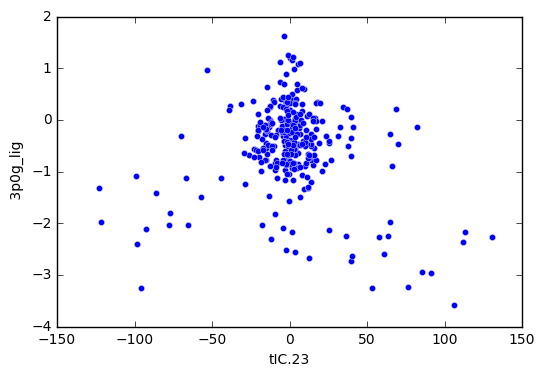

In [426]:
deltas_tica.loc[deltas_tica["tm6_tm3_dist"] < 12.].plot(x="tIC.23", y=" 3p0g_lig", kind='scatter')

In [32]:
deltas_tica["carv_div_cara"] = deltas_tica[" s-carvedilol"].subtract(deltas_tica[" s-carazolol"])
deltas_tica["3p0g_div_cara"] = deltas_tica[" 3p0g_lig"].subtract(deltas_tica[" s-carazolol"])
deltas_tica["neb_div_cara"] = deltas_tica[" nebivolol"].subtract(deltas_tica[" s-carazolol"])

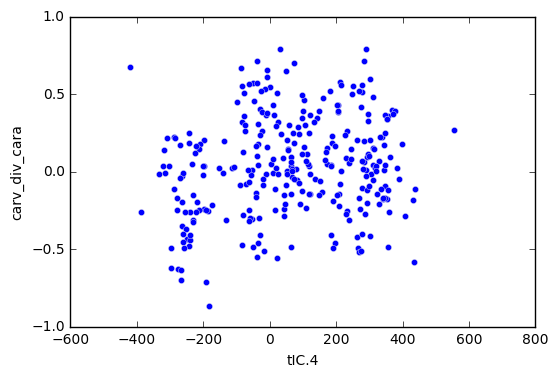

In [33]:
deltas_tica.loc[deltas_tica["tm6_tm3_dist"] <  12.].plot(x = "tIC.4", y = "carv_div_cara", kind='scatter')

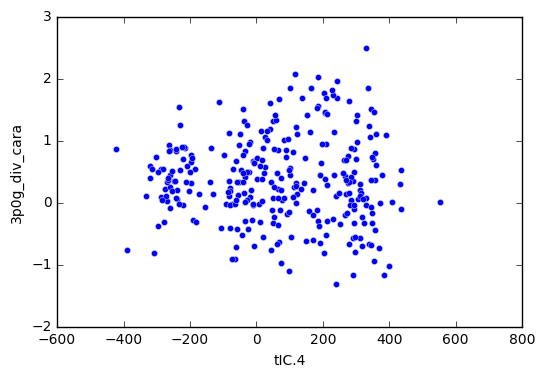

In [34]:
deltas_tica.loc[deltas_tica["tm6_tm3_dist"] <  12.].plot(x = "tIC.4", y = "3p0g_div_cara", kind='scatter')

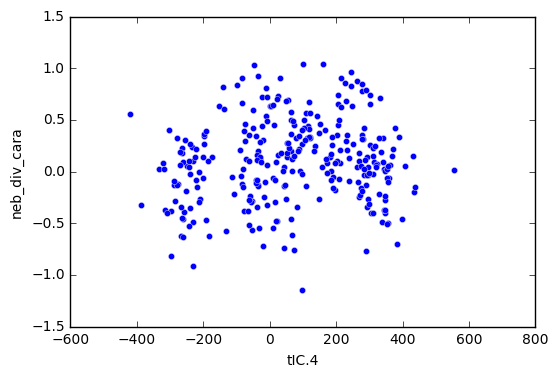

In [35]:
deltas_tica.loc[deltas_tica["tm6_tm3_dist"] < 12.].plot(x = "tIC.4", y = "neb_div_cara", kind='scatter')

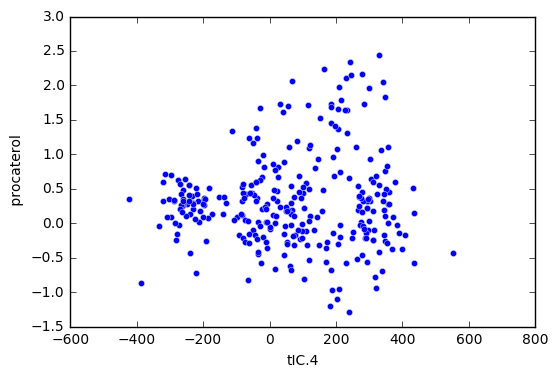

In [36]:
deltas_tica.loc[deltas_tica["tm6_tm3_dist"] < 12.].plot(x="tIC.4", y=procaterol, kind='scatter')

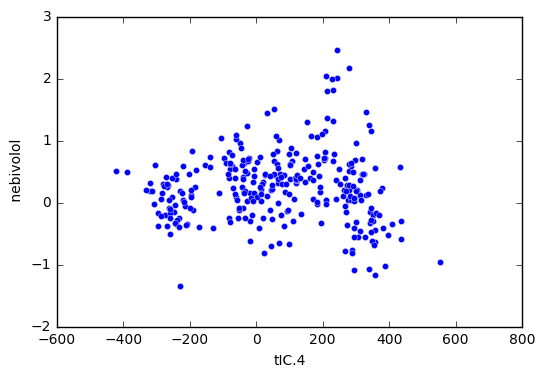

In [37]:
deltas_tica.loc[deltas_tica["tm6_tm3_dist"] < 12.].plot(x="tIC.4", y=" nebivolol", kind='scatter')

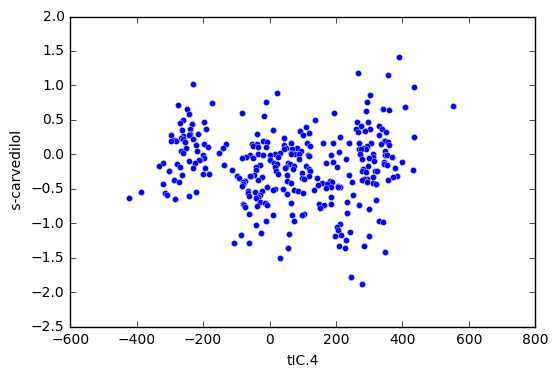

In [433]:
deltas_tica.loc[deltas_tica["tm6_tm3_dist"] < 12.].plot(x="tIC.4", y=" s-carvedilol", kind='scatter')

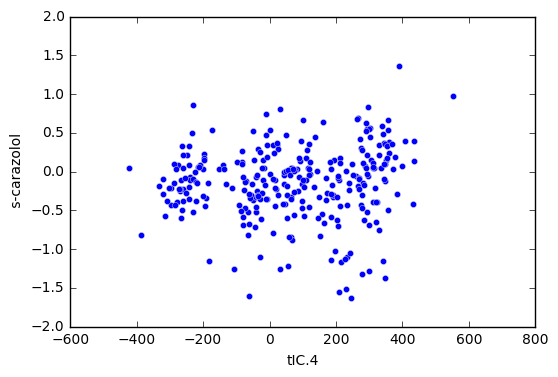

In [434]:
deltas_tica.loc[deltas_tica["tm6_tm3_dist"] < 12.].plot(x="tIC.4", y=" s-carazolol", kind='scatter')

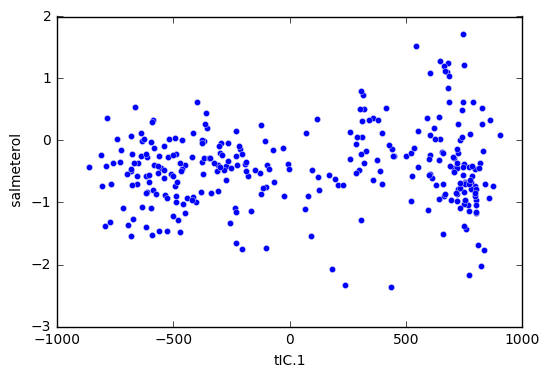

In [435]:
deltas_tica.loc[deltas_tica["tm6_tm3_dist"] < 12.].plot(x="tIC.1", y=" salmeterol", kind='scatter')

In [77]:
print(biased_antagonists)
#agonist_states = deltas_tica.loc[(deltas_tica[agonists].min(axis=1) > deltas_tica[biased_antagonists + inverse_agonists].max(axis=1)) & (deltas_tica[agonists].min(axis=1) > 1.0)]
from sklearn.preprocessing import scale
train_biased_antagonists = [" s-carvedilol", " nebivolol", " 3p0g_lig"]
docking_normalized = copy.deepcopy(population_deltas)
docking_normalized[docking_normalized.columns.values] = scale(population_deltas.values)

agonist_minus_antagonists = deltas_tica[train_agonists].mean(axis=1).values - deltas_tica[train_inverse_agonists + train_biased_antagonists].mean(axis=1).values
agonist_minus_antagonists = (agonist_minus_antagonists - np.mean(agonist_minus_antagonists))/np.std(agonist_minus_antagonists)
agonist_states = deltas_tica.iloc[np.where(agonist_minus_antagonists > 2.0)].loc[docking_normalized[train_agonists].min(axis=1) > 1.]

bias_antagonist_minus_antagonists = deltas_tica[train_biased_antagonists].max(axis=1).values - deltas_tica[train_inverse_agonists].min(axis=1).values
bias_antagonist_minus_antagonists = scale(bias_antagonist_minus_antagonists)

bias_antagonist_minus_agonists = deltas_tica[[" 3p0g_lig"]].mean(axis=1).values - deltas_tica[train_agonists].mean(axis=1).values
bias_antagonist_minus_agonists = scale(bias_antagonist_minus_agonists)
indices = list(set(np.where(bias_antagonist_minus_antagonists < -.5)[0]))#.tolist()).intersection(set(np.where(bias_antagonist_minus_antagonists > 1.)[0].tolist())))
print(np.where(scale(deltas_tica[train_biased_antagonists].mean(axis=1).values) < -.5)[0])
biased_antagonist_states = deltas_tica.iloc[list(set(indices).intersection(set(np.where(np.max(scale(deltas_tica[train_biased_antagonists].values),axis=1) < -.5)[0])))]
print(biased_antagonist_states)






[' s-carvedilol']
[  0   1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  17  18
  19  20  21  22  23  24  25  27  28  29  31  32  33  34  35  37  38  40
  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  58  61
  62  63  64  66  67  68  69  70  72  73  79  80  82  83  84  87  88  91
  92  93  96  98 100 101 104 105 108 110 111 112 114 118 125 127 130 131
 137 141 142 145 146 149 151 152 153 155 159 163 164 165 166 169 176 183
 185 190 191 192 196 197 198 199 200 210 215 216 217 218 221 229 235 247
 257 264 267 282 296 314 329 332 350 351 357 365 382 407]
             Compound_A   isoetharine   Carvedilol   3p0g_lig   Compound_F  \
cluster13      0.072419     -0.028882    -0.413425  -0.685078     0.192990   
cluster482    -0.818834     -0.426035    -0.120261  -1.220498    -0.989030   
cluster132    -0.731521     -0.139455    -0.945915  -0.713301    -0.937300   
cluster447    -0.202316      0.111183     0.389506  -0.041763    -0.862546   
cluster385    -0.413501

In [78]:
agonist_population = new_populations.loc[agonist_states.index].sum(axis=0)
agonist_ori = msm_cluster_eq_pops_df.loc[agonist_states.index].sum().values[0]
agonist_change = agonist_population.divide(agonist_ori)


biased_population = new_populations.loc[biased_antagonist_states.index].sum(axis=0)
biased_antagonist_ori = msm_cluster_eq_pops_df.loc[biased_antagonist_states.index].sum().values[0]
biased_antagonist_change = biased_population.divide(biased_antagonist_ori)



#gprot_population = new_populations.loc[gprot_agonist_states.index].sum(axis=0)
#gprot_ori = msm_cluster_eq_pops_df.loc[gprot_agonist_states.index].sum().values[0]
#gprot_change = gprot_population.divide(gprot_ori)



#arrestin_agonist_population = new_populations.loc[arrestin_agonist_states.index].sum(axis=0)
#arrestin_agonist_ori = msm_cluster_eq_pops_df.loc[arrestin_agonist_states.index].sum().values[0]
#arrestin_agonist_change = arrestin_agonist_population.divide(arrestin_agonist_ori)

#biased_vs_agonist_state_change = biased_antagonist_change.divide(agonist_change)
#biased_vs_agonist_state_change /= biased_vs_agonist_state_change[" r_isopreterenol"]

#biased_antagonist_vs_gprot_agonist_state_change = biased_antagonist_change.divide(gprot_change)
#biased_antagonist_vs_gprot_agonist_state_change /= biased_antagonist_vs_gprot_agonist_state_change[" r_isopreterenol"]

print("Agonist state changes:")
print(agonist_change)
print("Arrestin antagonist state  changes:")
print(biased_antagonist_change)
print(type(biased_antagonist_change))
biased_antagonist_change.sort()
print(biased_antagonist_change)
#print("Gprot agonist state changes:")
#print(gprot_change)
#print("Arrestin agonist state changes:")
##print(arrestin_agonist_change)
#print("Biased antagonist state change vs. Agonist state change")
#print(biased_vs_agonist_state_change)
#print("Biased antagonist vs Gprot agonist state change")
#print(biased_antagonist_vs_gprot_agonist_state_change)



Agonist state changes:
 Compound_A        NaN
 isoetharine       NaN
 Carvedilol        NaN
 3p0g_lig          NaN
 Compound_F        NaN
 procaterol        NaN
 Compound_H        NaN
 Compound_B        NaN
 r_epinephrine     NaN
 s-atenolol        NaN
 Compound_E        NaN
 nebivolol         NaN
 Compound_G        NaN
 Compound_J        NaN
 r_isopreterenol   NaN
 s-carvedilol      NaN
 s-carazolol       NaN
 salmeterol        NaN
 Compound_D        NaN
 Compound_C        NaN
 Compound_I        NaN
 xamoterol         NaN
 Xamoterol         NaN
dtype: float64
Arrestin antagonist state  changes:
 Compound_A         1.927813
 isoetharine        1.514180
 Carvedilol         1.791782
 3p0g_lig           2.682177
 Compound_F         2.154721
 procaterol         1.592815
 Compound_H         1.714786
 Compound_B         1.628878
 r_epinephrine      1.391914
 s-atenolol         1.398941
 Compound_E         1.846316
 nebivolol          2.216228
 Compound_G         1.741877
 Compound_J         

In [76]:
pd.set_option('display.max_columns', None)

In [40]:
deltas_tica.loc[agonist_states.index]

,Compound_A,isoetharine,Carvedilol,3p0g_lig,Compound_F,procaterol,Compound_H,Compound_B,r_epinephrine,s-atenolol,Compound_E,nebivolol,Compound_G,Compound_J,r_isopreterenol,s-carvedilol,s-carazolol,salmeterol,Compound_D,Compound_C,Compound_I,xamoterol,Xamoterol,tIC.1,tIC.2,tIC.3,tIC.4,tIC.5,tIC.6,tIC.7,tIC.8,tIC.9,tIC.10,tIC.11,tIC.12,tIC.13,tIC.14,tIC.15,tIC.16,tIC.17,tIC.18,tIC.19,tIC.20,tIC.21,tIC.22,tIC.23,tIC.24,tIC.25,tm6_tm3_dist,rmsd_npxxy_inactive,rmsd_npxxy_active,rmsd_connector_inactive,rmsd_connector_active,carv_div_cara,3p0g_div_cara,neb_div_cara


In [45]:
deltas_tica.loc[biased_antagonist_states.index]

,Compound_A,isoetharine,Carvedilol,3p0g_lig,Compound_F,procaterol,Compound_H,Compound_B,r_epinephrine,s-atenolol,Compound_E,nebivolol,Compound_G,Compound_J,r_isopreterenol,s-carvedilol,s-carazolol,salmeterol,Compound_D,Compound_C,Compound_I,xamoterol,Xamoterol,tIC.1,tIC.2,tIC.3,tIC.4,tIC.5,tIC.6,tIC.7,tIC.8,tIC.9,tIC.10,tIC.11,tIC.12,tIC.13,tIC.14,tIC.15,tIC.16,tIC.17,tIC.18,tIC.19,tIC.20,tIC.21,tIC.22,tIC.23,tIC.24,tIC.25,tm6_tm3_dist,rmsd_npxxy_inactive,rmsd_npxxy_active,rmsd_connector_inactive,rmsd_connector_active,carv_div_cara,3p0g_div_cara,neb_div_cara
cluster131,-0.768656,0.119259,-1.219934,-0.267520,-0.291236,0.193731,-0.593488,-0.449511,0.051186,-0.313757,-1.095211,-0.785162,-0.695696,-0.484487,0.023041,-1.181201,-0.688083,-0.509455,-0.283410,-0.238026,-0.313198,-0.683386,-0.815877,319.800825,-137.119785,-28.156732,267.016503,169.641026,-294.248335,9.278550,60.394381,534.791052,-8.215936,-36.186552,-9.541857,-118.223914,13.990390,-14.819902,17.858777,9.245422,22.979217,-12.416510,2.474262,-6.173483,-39.698998,-6.025501,-30.256661,-50.510792,8.487348,0.648388,1.010855,0.425432,1.550649,-0.493119,0.420562,-0.097080
cluster305,-0.752704,0.010161,-1.201949,-0.305451,-0.796834,0.275767,-0.680219,-1.212326,-0.016228,-0.794955,-1.235826,-1.163677,-0.809877,-0.314002,-0.102324,-1.151016,-0.663997,-0.794437,-0.870341,-0.735491,-0.389762,-0.797567,-0.613875,306.882350,-131.247820,-107.350364,356.229175,206.988133,-292.501435,-75.785859,35.840912,492.519905,3.104660,-14.258620,20.982315,-57.319467,38.634446,2.630293,54.468884,-0.471459,14.519721,-16.446422,-57.363379,13.661910,-39.204924,-31.515050,-56.019620,-37.126071,8.081040,0.589445,1.002077,0.418182,1.558338,-0.487019,0.358546,-0.499680
cluster132,-0.731521,-0.139455,-0.945915,-0.713301,-0.937300,0.229850,-0.501452,-0.197859,-0.230911,0.073112,-1.007242,-0.601626,-0.465393,-0.346702,0.115076,-0.918366,-0.209713,-0.943036,-0.489258,-0.369657,-0.349262,-0.713350,-0.248041,195.890165,510.702255,396.144223,-237.817003,82.841123,-182.095096,80.090109,2.210586,-35.515018,-180.085945,-239.292018,99.779328,-116.808782,1.812588,-25.911416,-134.134403,-110.711055,48.454071,42.687602,169.782184,-44.193168,4.610992,103.027486,-60.012258,1.977370,15.790714,0.727801,1.093197,1.815477,1.648853,-0.708652,-0.503588,-0.391913
cluster460,-0.807985,-0.018686,-0.777362,0.144552,-0.277697,0.466520,-0.862583,-0.357689,0.303642,-0.396802,-0.995256,-0.820424,-0.859057,-0.455699,0.133162,-0.894179,-0.338027,-0.022150,-0.413222,-0.599637,-0.685992,-0.797947,-0.575622,647.873326,99.732581,-42.491678,23.231142,-38.732737,10.579857,-12.369607,22.905801,-9.829828,1.127985,-36.144702,34.972324,-165.582932,-50.588241,54.214333,-92.330011,169.643989,-8.117512,-113.693215,78.525831,35.794576,-4.093773,40.719910,33.201889,-4.214510,8.596544,0.575117,0.837308,0.495227,1.369919,-0.556152,0.482579,-0.482396
cluster416,0.081247,-0.389104,-0.513381,-0.726067,-0.243483,-0.159082,-0.344434,-0.534941,-0.318910,0.107113,-0.388658,-0.693692,-0.748592,-0.274067,-0.164056,-0.240815,0.045921,0.566148,-0.381040,-0.364123,-0.435228,-0.214733,-0.702041,782.830599,-151.017244,418.960732,43.017184,544.597601,-92.378731,637.510595,-40.118608,-92.646083,2.006891,-71.500505,72.723157,76.505415,15.637567,52.228320,3.556135,-41.437444,4.861938,10.099137,-20.062368,22.200846,-5.174886,-5.989742,21.579383,-3.470394,8.317831,0.597770,0.877664,0.597611,1.616992,-0.286735,-0.771988,-0.739613
cluster124,-0.558959,-0.132609,-0.449036,0.128228,-0.168971,0.630146,-0.628806,-0.555996,0.232418,-0.099992,-0.428013,-0.203364,-0.765581,0.126794,0.235788,-0.713270,-0.086968,1.275059,-0.758946,-0.530561,-0.350550,-0.735988,-0.465879,306.505927,-276.260834,36.449137,-275.544629,-61.784330,177.236043,78.949778,-29.000053,-14.520527,-8.559414,-79.768824,-125.191205,-169.682126,37.837089,47.755135,94.146695,-80.358554,-5.764375,13.807775,-28.463582,-6.608912,-50.082376,-20.574815,-45.277040,28.896467,7.865702,0.397561,0.998027,0.352021,1.390293,-0.62

In [440]:
deltas_tica.loc[gprot_agonist_states.index]

,Compound_A,isoetharine,Carvedilol,3p0g_lig,Compound_F,procaterol,Compound_H,Compound_B,r_epinephrine,s-atenolol,Compound_E,nebivolol,Compound_G,Compound_J,r_isopreterenol,s-carvedilol,s-carazolol,salmeterol,Compound_D,Compound_C,Compound_I,xamoterol,Xamoterol,tIC.1,tIC.2,tIC.3,tIC.4,tIC.5,tIC.6,tIC.7,tIC.8,tIC.9,tIC.10,tIC.11,tIC.12,tIC.13,tIC.14,tIC.15,tIC.16,tIC.17,tIC.18,tIC.19,tIC.20,tIC.21,tIC.22,tIC.23,tIC.24,tIC.25,tm6_tm3_dist,rmsd_npxxy_inactive,rmsd_npxxy_active,rmsd_connector_inactive,rmsd_connector_active,carv_div_cara,3p0g_div_cara,neb_div_cara
cluster310,0.030261,0.126479,0.034206,0.248925,0.028641,0.580673,-0.082891,0.113716,0.064419,0.150795,0.448316,0.290767,0.018300,-0.180708,0.203381,0.250656,0.140821,0.530510,0.150948,-0.062186,-0.189331,-0.166843,-0.189901,416.714944,49.458516,-159.572044,436.099090,-54.831547,-134.735183,-33.716560,13.575308,-49.213874,-4.176964,55.471976,13.000676,-26.200539,-38.566562,30.001068,-25.473295,8.473123,-4.941961,-22.285808,6.832599,4.150207,8.092296,-4.569328,12.119252,-10.325363,8.378828,0.583476,0.896869,0.369578,1.419320,1.779966,1.767672,2.064802
cluster352,0.224102,0.326420,0.203646,0.262816,0.282465,0.698264,0.289883,0.106257,0.379243,-0.015264,0.290390,-0.322625,0.050491,0.424883,0.209138,0.247264,0.601028,-0.894182,-0.235727,0.042188,0.239360,0.178482,0.256073,-594.958444,500.247967,-171.879525,49.586151,-12.256089,124.490179,91.790597,-0.877958,22.623222,-141.871674,52.638238,-5.097777,-8.006117,1.516951,9.900705,10.741427,-1.547644,-24.778096,18.354164,40.756737,3.810750,-16.971580,-62.460330,-8.105014,8.646914,14.066558,0.443347,0.873155,0.463740,1.386937,0.411401,0.437277,-0.536789
cluster86,0.033716,0.079100,0.052910,0.256446,-0.713121,0.578028,0.110680,-0.494863,0.286456,-0.011467,0.168120,-0.366612,-0.308662,-0.092870,0.102119,0.223611,0.334392,-0.638252,-0.338681,-0.249865,-0.144193,-0.250821,0.049420,-202.051723,637.774338,-102.012661,71.104381,-157.775452,-173.127256,71.832017,-24.570966,-27.575140,30.134733,-162.517744,-118.298544,15.459123,87.624730,7.207755,-5.068743,7.735363,-25.703718,19.588436,-26.036355,9.343478,-3.214184,18.121504,-15.216837,9.899010,14.246911,1.061612,0.353296,1.579927,0.750389,0.668708,0.766903,-1.096354
cluster49,-0.059428,0.303157,0.132600,0.154153,-0.060032,0.579434,0.253404,-0.008507,0.470863,0.247156,-0.191390,-0.372322,0.242761,-0.214480,0.494942,0.183334,0.168048,-0.108179,0.125309,0.280208,0.142897,0.244685,-0.050840,-1089.900732,145.519349,-144.769591,-96.323344,183.303816,-52.892867,-31.563940,330.577015,-21.278625,-61.994471,102.770684,58.427839,32.683552,-6.779943,24.745063,5.265692,-32.331595,-74.186733,15.123352,-6.365167,-13.921349,-3.818022,-10.967418,-7.249210,18.219396,13.114554,0.442923,0.846810,0.473553,1.570497,1.090958,0.917311,-2.215563
cluster134,0.076618,0.741040,-0.114412,1.166113,-0.016276,1.283119,-0.252971,0.126975,0.470450,-0.398615,0.109582,-0.054406,0.098659,0.115410,0.693456,0.165750,-0.148209,-0.199866,0.121959,0.185019,0.112210,-0.217408,-0.156196,524.701369,54.595553,-162.798138,239.671671,-159.186651,-124.605882,28.827864,10.499705,-29.944036,-9.770266,65.511667,15.704818,-13.299238,-67.577883,43.342481,-19.144279,25.682475,-6.762716,-43.647698,22.162337,-1.265567,42.013654,1.840841,26.046533,-4.395102,8.483020,0.588817,0.825450,0.342708,1.369958,-1.118353,-7.868022,0.367086
cluster271,-0.098724,0.485493,0.084153,-0.090511,-0.365695,0.729238,-0.012610,-0.383303,0.305500,0.019776,-0.460453,-0.047652,-0.687135,0.031907,0.334662,0.131837,-0.130498,1.724208,-0.525004,-0.295888,0.123934,-0.529661,-0.330070,746.749735,-165.744391,-76.239557,-221.856386,-29.083991,-85.330963,7.933362,-0.256210,-17.588235,-21.679366,141.382247,21.075328,1.344564,37.614341,-53.058330,-16.069668,9.645754,-10.529118,-13.910286,-10.262684,-15.931278,-10.963523,6.865036,-9.003388,32.009627,7.835804,0.540429,0.958693,0.333340,1.513159,-1.010261,0.693578,0.365154
cluster14,0.155245,0.237229,0.076839,0.411525,0.267491,0.96287

In [441]:
deltas_tica.loc[arrestin_agonist_states.index]

,Compound_A,isoetharine,Carvedilol,3p0g_lig,Compound_F,procaterol,Compound_H,Compound_B,r_epinephrine,s-atenolol,Compound_E,nebivolol,Compound_G,Compound_J,r_isopreterenol,s-carvedilol,s-carazolol,salmeterol,Compound_D,Compound_C,Compound_I,xamoterol,Xamoterol,tIC.1,tIC.2,tIC.3,tIC.4,tIC.5,tIC.6,tIC.7,tIC.8,tIC.9,tIC.10,tIC.11,tIC.12,tIC.13,tIC.14,tIC.15,tIC.16,tIC.17,tIC.18,tIC.19,tIC.20,tIC.21,tIC.22,tIC.23,tIC.24,tIC.25,tm6_tm3_dist,rmsd_npxxy_inactive,rmsd_npxxy_active,rmsd_connector_inactive,rmsd_connector_active,carv_div_cara,3p0g_div_cara,neb_div_cara
cluster408,0.133476,0.452343,0.661003,-0.127727,0.397205,-0.149779,-0.005093,0.599197,0.303866,0.834526,0.409197,0.589182,0.333998,0.301724,0.229329,0.978104,0.391452,0.310425,-0.018304,0.091862,-0.168466,0.274922,0.258980,313.815403,-14.900569,-121.117053,435.232789,-75.755496,-154.140519,10.110987,25.325792,-18.133838,-7.471509,50.244917,5.742427,-0.524480,-37.772389,-3.960164,-5.572389,-8.338119,-0.322627,10.232367,14.460882,-12.295921,-35.454386,-19.787405,4.589632,-21.234841,7.939928,0.631147,1.010584,0.433912,1.513823,2.498656,-0.326290,1.505118
cluster9,0.108791,0.424608,0.322168,-0.114796,0.278987,-0.393047,0.531422,0.004162,0.066698,-0.235292,0.619362,0.361163,0.159863,0.256705,-0.208123,0.525402,-0.295083,0.539906,0.064778,-0.158523,0.040682,-0.035447,0.223111,459.488119,374.063458,414.239927,-201.799607,52.593218,-133.420119,24.856577,3.507500,-48.787522,-93.213292,-209.267794,48.232126,-77.917805,-9.790613,-11.083573,-119.072868,-85.223505,29.891020,41.307068,165.828369,-42.177348,-8.350187,70.737748,-40.128385,-0.720899,13.961195,0.807586,1.052638,1.617430,1.574933,-1.780522,0.389028,-1.223936
cluster462,0.288544,0.738562,0.365688,-0.272576,0.072407,-0.132977,0.157092,0.394365,-0.043299,0.093911,0.263332,0.278617,0.170850,-0.273175,-0.157486,0.365589,-0.074663,-2.336440,0.115415,0.083247,-0.144548,0.151424,0.251382,238.644220,-244.975983,-41.130116,-239.909264,-55.285970,248.037541,77.005884,-23.697826,-15.053372,0.846100,-99.114635,-101.907343,-170.679386,43.885168,-1.530643,95.682433,-57.755600,-4.649241,1.960288,-26.546838,6.311525,-64.563656,-16.174926,-15.528646,25.169456,7.841381,0.362170,0.914521,0.329647,1.417242,-4.896516,3.650741,-3.731651
cluster438,-0.168546,0.433972,-0.228651,-0.374849,-0.288100,-0.084783,-0.080398,-0.336208,0.305828,-0.194412,-0.197824,-0.492623,0.244460,-0.154831,0.257724,-0.132167,-0.767619,-1.033680,-0.326425,0.366290,0.491279,-0.436816,0.037275,-361.062832,273.760903,-82.854538,-244.704812,19.497095,-119.981412,-44.650000,0.089232,-8.552131,-93.713307,-103.341999,-61.448799,48.510599,25.952798,-6.522804,-21.582855,15.266909,-37.633699,3.616905,-45.004553,12.629549,15.802323,36.356145,13.978093,-18.841943,13.554860,0.832620,0.525039,1.241450,1.018338,0.172178,0.488326,0.641754
cluster238,0.302071,0.329155,-0.069135,0.182184,0.107283,-0.191634,0.268218,0.090692,0.230494,0.565954,0.419192,0.475143,0.033910,0.155152,0.104107,-0.146501,0.102547,-0.691164,0.359724,0.072373,0.396628,-0.070917,-0.019759,753.853394,42.197687,140.087196,345.993594,155.041077,77.403964,-195.519090,-23.377739,-91.502085,17.025094,-22.118666,6.371589,13.832702,-2.695199,5.661985,11.356387,13.505333,-5.572247,4.296369,7.094026,9.141361,-14.100600,-0.078534,7.803296,11.787049,7.738497,0.586474,0.888005,0.499413,1.397839,-1.428629,1.776598,4.633430
cluster445,0.690945,0.630596,0.282123,0.879109,0.622225,0.029491,0.689627,0.473467,0.251336,0.464796,0.387167,0.407534,0.627134,0.479976,0.261182,-0.315776,-0.291412,-0.265689,0.762832,0.371781,0.589287,0.258992,-0.087367,703.544058,9.667201,-101.712950,382.826057,181.556467,65.028546,-215.506095,-24.551043,-75.627878,17.968490,-22.326654,0.821590,31.895413,3.365776,12.786788,-0.088684,-14.530200,-2.687352,10.213360,-15.191523,20.444091,-11.570286,-2.632195,-15.361773,-1.954102,7.728516,0.551524,0.874825,0.344337,1.438937,1.083609,-3.016724,-1.398483


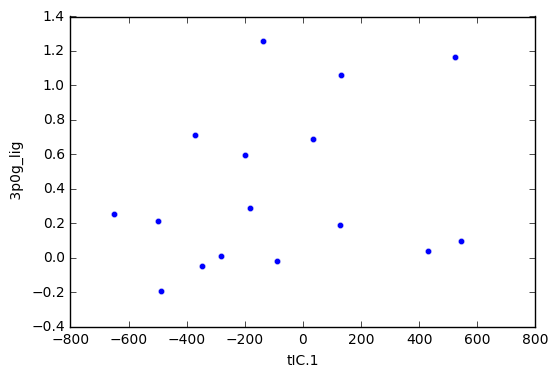

In [442]:
deltas_tica.loc[agonist_states.index].plot(x="tIC.1",y=" 3p0g_lig", kind='scatter')

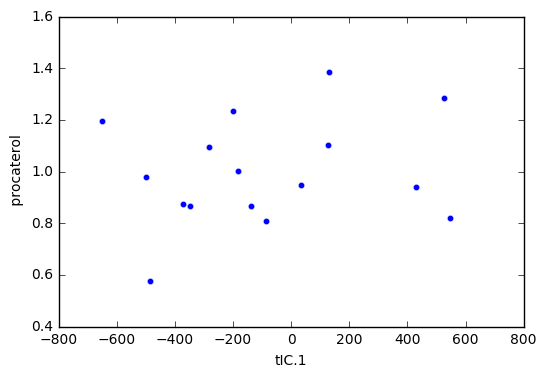

In [443]:
deltas_tica.loc[agonist_states.index].plot(x="tIC.1",y=procaterol, kind='scatter')

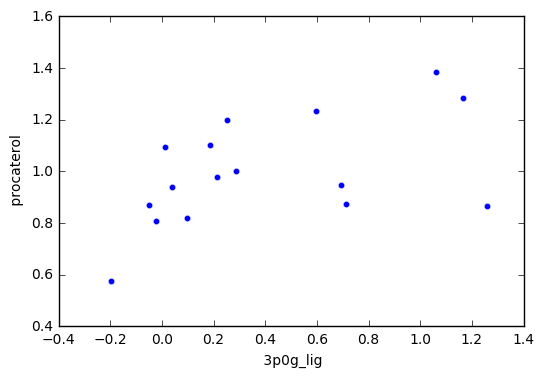

In [444]:
deltas_tica.loc[agonist_states.index].plot(x=" 3p0g_lig",y=procaterol, kind='scatter')

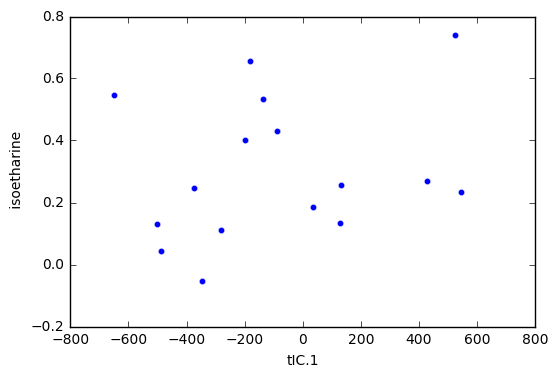

In [445]:
deltas_tica.loc[agonist_states.index].plot(x="tIC.1",y=" isoetharine", kind='scatter')

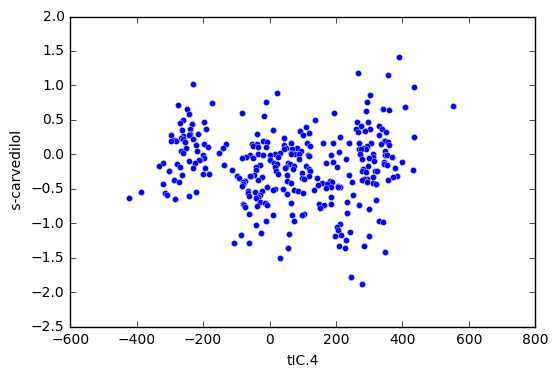

In [446]:
deltas_tica.loc[deltas_tica["tm6_tm3_dist"] < 12.].plot(x="tIC.4",y=" s-carvedilol", kind='scatter')

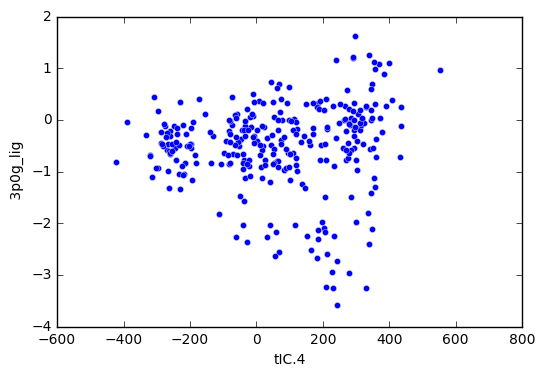

In [447]:
deltas_tica.loc[deltas_tica["tm6_tm3_dist"] < 12.].plot(x="tIC.4",y=" 3p0g_lig", kind='scatter')

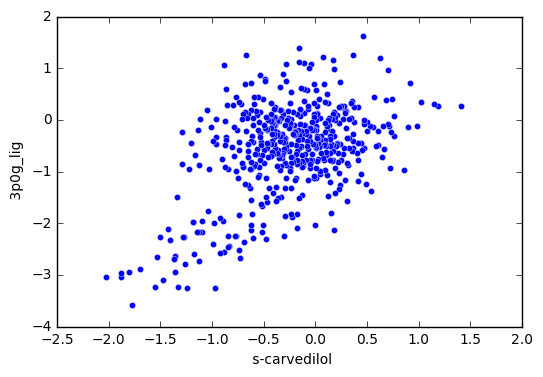

In [448]:
deltas_tica.loc[deltas_tica["tm6_tm3_dist"] < 16.].plot(x=" s-carvedilol",y=" 3p0g_lig", kind='scatter')

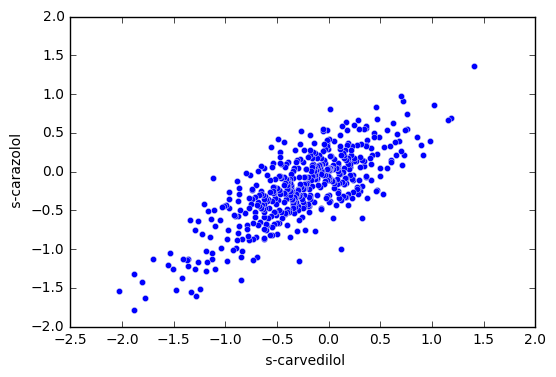

In [449]:
deltas_tica.loc[deltas_tica["tm6_tm3_dist"] < 16.].plot(x=" s-carvedilol",y=" s-carazolol", kind='scatter')

In [450]:
import scipy.stats as stats
print(stats.pearsonr(deltas_tica[" s-carazolol"].values, deltas_tica["tIC.1"].values))
#print(stats.pearsonr(deltas_tica[" s-carvedilol"].values, deltas_tica["tIC.1"].values))
print(stats.pearsonr(deltas_tica[" nebivolol"].values, deltas_tica["tIC.1"].values))
print(stats.pearsonr(deltas_tica[" xamoterol"].values, deltas_tica["tIC.1"].values))
print(stats.pearsonr(deltas_tica[" Compound_A"].values, deltas_tica["tIC.1"].values))
print(stats.pearsonr(deltas_tica[" Compound_B"].values, deltas_tica["tIC.1"].values))
print(stats.pearsonr(deltas_tica[" Compound_C"].values, deltas_tica["tIC.1"].values))
print(stats.pearsonr(deltas_tica[" Compound_D"].values, deltas_tica["tIC.1"].values))
print(stats.pearsonr(deltas_tica[" Compound_E"].values, deltas_tica["tIC.1"].values))
print(stats.pearsonr(deltas_tica[" Compound_F"].values, deltas_tica["tIC.1"].values))
print(stats.pearsonr(deltas_tica[" Compound_G"].values, deltas_tica["tIC.1"].values))
print(stats.pearsonr(deltas_tica[" Compound_H"].values, deltas_tica["tIC.1"].values))
print(stats.pearsonr(deltas_tica[" Compound_I"].values, deltas_tica["tIC.1"].values))
print(stats.pearsonr(deltas_tica[" Compound_J"].values, deltas_tica["tIC.1"].values))

(0.1640940403052559, 0.00022863139925589489)
(0.45944975725444903, 1.7658756813474711e-27)
(0.18279797684204191, 3.9232519894772178e-05)
(0.31593363765125587, 4.7285249959818589e-13)
(0.20817200452929938, 2.6693794087080302e-06)
(0.17065511549379703, 0.00012578011485385262)
(0.30589039452568001, 2.7280957383151562e-12)
(0.27831680829269168, 2.3991763411825017e-10)
(0.27898169026783798, 2.1658632875326153e-10)
(0.25875232726430752, 4.3138532455180378e-09)
(0.26337924592839568, 2.2243809230507204e-09)
(0.19370658628260068, 1.2890748582607394e-05)
(0.27629858337260693, 3.2674106550109251e-10)


In [451]:
deltas_tica.loc[biased_antagonist_states.index][[" 3p0g_lig", " nebivolol", " s-carvedilol", " s-carazolol", "tIC.1", "tIC.4", "tm6_tm3_dist", "tIC.3"]]

,3p0g_lig,nebivolol,s-carvedilol,s-carazolol,tIC.1,tIC.4,tm6_tm3_dist,tIC.3
cluster131,0.267520,0.785162,1.181201,0.688083,319.800825,267.016503,8.487348,-28.156732
cluster305,0.305451,1.163677,1.151016,0.663997,306.882350,356.229175,8.081040,-107.350364
cluster132,0.713301,0.601626,0.918366,0.209713,195.890165,-237.817003,15.790714,396.144223
cluster416,0.726067,0.693692,0.240815,-0.045921,782.830599,43.017184,8.317831,418.960732
cluster8,0.386412,0.344887,0.681959,0.394207,641.984242,408.225342,7.847084,-59.200591
cluster41,0.010141,0.049949,0.325005,-0.193530,803.786704,267.554483,7.894433,-6.981216
cluster12,0.175087,0.175245,0.285601,-0.209551,660.712294,-297.164183,8.358621,18.142094


In [452]:
deltas_tica.loc[agonist_states.index][[" 3p0g_lig", " nebivolol", " s-carvedilol", " s-carazolol", "tIC.1", "tIC.4", "tm6_tm3_dist", "tIC.3"]]

,3p0g_lig,nebivolol,s-carvedilol,s-carazolol,tIC.1,tIC.4,tm6_tm3_dist,tIC.3
cluster134,1.166113,-0.054406,0.165750,-0.148209,524.701369,239.671671,8.483020,-162.798138
cluster56,0.252214,-0.006878,-0.393672,0.128859,-650.857412,182.677270,11.836732,-203.409981
cluster102,0.213455,-0.421803,-0.399897,-0.168133,-499.969989,188.746719,9.095563,-182.466574
cluster468,-0.049120,-0.490194,-0.548605,-0.812974,-347.772744,-388.313139,11.949228,-37.253450
cluster335,0.096765,-0.533410,-0.562337,-0.813489,545.279784,-63.389944,7.686516,-75.152008
cluster36,0.711454,-0.447387,-0.625765,-0.416367,-372.780010,-60.387966,12.395721,-112.615380
cluster5,0.039498,-0.697427,-0.660271,-0.654207,428.926604,319.259901,9.080733,-201.176902
cluster498,1.257934,-0.149990,-0.670985,-0.450403,-136.742112,81.536540,14.533322,-164.811152
cluster230,0.691406,-0.550802,-0.682413,0.000752,34.509946,153.251508,12.771239,-196.107663
cluster397,0.288391,-0.849665,-0.853176,-0.491617,-181.410535,91.449711,12.963167,-157.560760


(array([  1,   2,   4,   5,   6,   7,  11,  13,  15,  16,  18,  21,  22,
        25,  27,  28,  29,  31,  35,  39,  41,  44,  45,  48,  55,  56,
        59,  61,  63,  64,  66,  68,  73,  74,  75,  76,  77,  78,  86,
        90,  95,  98,  99, 104, 105, 107, 112, 113, 120, 123, 126, 132,
       138, 145, 156, 158, 169, 171, 185, 187, 207, 235, 245, 259, 268,
       270, 278, 309, 353, 412, 419, 437, 480]),)


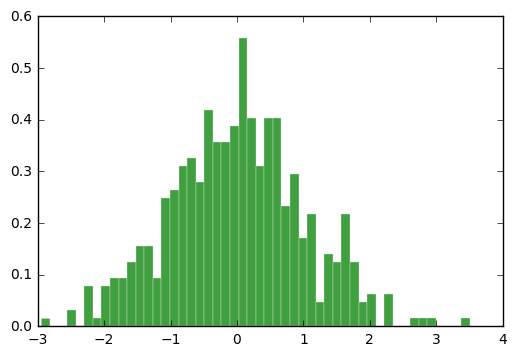

,s-carazolol,nebivolol,s-carvedilol,3p0g_lig,tIC.1,tIC.2,tIC.3,tIC.4
cluster131,0.688083,0.785162,1.181201,0.267520,319.800825,-137.119785,-28.156732,267.016503
cluster305,0.663997,1.163677,1.151016,0.305451,306.882350,-131.247820,-107.350364,356.229175
cluster408,0.391452,0.589182,0.978104,-0.127727,313.815403,-14.900569,-121.117053,435.232789
cluster132,0.209713,0.601626,0.918366,0.713301,195.890165,510.702255,396.144223,-237.817003
cluster460,0.338027,0.820424,0.894179,-0.144552,647.873326,99.732581,-42.491678,23.231142
cluster256,0.445466,-0.204705,0.859284,-0.962280,-414.780968,310.235456,514.768919,302.763428
cluster344,0.211119,0.275665,0.731688,-0.245027,-209.165308,610.042962,87.599266,134.843544
cluster124,0.086968,0.203364,0.713270,-0.128228,306.505927,-276.260834,36.449137,-275.544629
cluster336,0.262046,0.604142,0.698231,-0.083283,339.634207,521.322620,430.988563,-221.870742
cluster8,0.394207,0.344887,0.681959,0.386412,641.984242,14.474689,-59.200591,408.225342


In [453]:
x = deltas_tica[" s-carvedilol"].values - deltas_tica[" s-carazolol"].values
x = (x - np.mean(x))/np.std(x)
print(np.where(x > 1.))
n, bins, patches = plt.hist(x, 50, normed=1, facecolor='green', alpha=0.75)

#l = plt.plot(bins, y, 'r--', linewidth=1)
plt.show()
deltas_tica.iloc[np.where(x>1.)][[" s-carazolol", " nebivolol", " s-carvedilol", " 3p0g_lig", "tIC.1", "tIC.2", "tIC.3", "tIC.4"]]



(array([147, 261, 333, 341, 351, 373, 403, 433, 447, 466, 475]),)


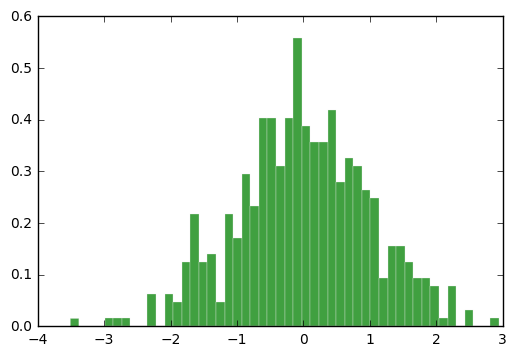

,s-carazolol,nebivolol,s-carvedilol,3p0g_lig,tIC.1,tIC.2,tIC.3,tIC.4
cluster403,0.805669,-0.098668,0.016772,-0.348926,-863.610940,-389.210678,-116.085946,30.976379
cluster493,0.525791,-0.267730,-0.263107,0.179445,-477.832430,-203.921274,-179.715132,290.958399
cluster44,0.378549,-0.254338,-0.429666,0.103370,-533.581645,350.977919,-196.342450,183.995485
cluster126,0.254596,-0.693457,-0.466185,-1.599466,-706.087228,174.297837,458.008490,-19.759055
cluster156,0.413032,-0.535022,-0.486683,0.755986,159.815842,528.083349,-168.452214,129.112365
cluster464,0.318176,-0.274044,-0.553072,0.443564,501.903027,597.168160,-79.471627,-75.266731
cluster466,0.073214,-0.713190,-0.652651,0.107102,-494.532143,174.473118,-97.198313,-142.659201
cluster429,-0.015844,-0.063131,-0.798642,0.279327,-330.703096,428.449607,-101.692407,-174.250548
cluster289,-0.120240,-0.751094,-0.888805,1.060447,129.898732,619.357066,-179.171324,91.425554
cluster316,-0.087744,-0.363781,-1.122675,-0.866173,-335.220475,163.177407,-45.381720,-482.568523


In [454]:
x = deltas_tica[" s-carazolol"].values - deltas_tica[" s-carvedilol"].values
x = (x - np.mean(x))/np.std(x)
print(np.where(x > 2.))
n, bins, patches = plt.hist(x, 50, normed=1, facecolor='green', alpha=0.75)

#l = plt.plot(bins, y, 'r--', linewidth=1)
plt.show()
deltas_tica.iloc[np.where(x>2.)][[" s-carazolol", " nebivolol", " s-carvedilol", " 3p0g_lig", "tIC.1", "tIC.2", "tIC.3", "tIC.4"]]




In [455]:
deltas_tica.loc[agonist_states.index]

,Compound_A,isoetharine,Carvedilol,3p0g_lig,Compound_F,procaterol,Compound_H,Compound_B,r_epinephrine,s-atenolol,Compound_E,nebivolol,Compound_G,Compound_J,r_isopreterenol,s-carvedilol,s-carazolol,salmeterol,Compound_D,Compound_C,Compound_I,xamoterol,Xamoterol,tIC.1,tIC.2,tIC.3,tIC.4,tIC.5,tIC.6,tIC.7,tIC.8,tIC.9,tIC.10,tIC.11,tIC.12,tIC.13,tIC.14,tIC.15,tIC.16,tIC.17,tIC.18,tIC.19,tIC.20,tIC.21,tIC.22,tIC.23,tIC.24,tIC.25,tm6_tm3_dist,rmsd_npxxy_inactive,rmsd_npxxy_active,rmsd_connector_inactive,rmsd_connector_active,carv_div_cara,3p0g_div_cara,neb_div_cara
cluster134,0.076618,0.741040,-0.114412,1.166113,-0.016276,1.283119,-0.252971,0.126975,0.470450,-0.398615,0.109582,-0.054406,0.098659,0.115410,0.693456,0.165750,-0.148209,-0.199866,0.121959,0.185019,0.112210,-0.217408,-0.156196,524.701369,54.595553,-162.798138,239.671671,-159.186651,-124.605882,28.827864,10.499705,-29.944036,-9.770266,65.511667,15.704818,-13.299238,-67.577883,43.342481,-19.144279,25.682475,-6.762716,-43.647698,22.162337,-1.265567,42.013654,1.840841,26.046533,-4.395102,8.483020,0.588817,0.825450,0.342708,1.369958,-1.118353,-7.868022,0.367086
cluster56,-0.134200,0.547617,-0.336639,0.252214,0.132579,1.197012,0.288431,-0.072096,0.119557,-0.140750,0.119155,-0.006878,-0.073978,0.141814,0.216836,-0.393672,0.128859,-0.359851,-0.122296,-0.190047,0.118958,-0.167621,-0.050379,-650.857412,341.987597,-203.409981,182.677270,16.953227,177.792869,95.243034,35.314250,15.622587,-151.007240,77.504572,-5.791798,-31.114443,-14.406519,-6.094460,-10.356341,-14.469093,93.956039,8.060500,-17.402610,-5.338132,6.919184,34.742570,-6.870792,-4.175488,11.836732,0.444687,0.862668,0.410999,1.621575,-3.055051,1.957278,-0.053374
cluster102,-0.152625,0.131675,-0.643798,0.213455,-0.042413,0.977287,-0.050244,-0.061038,0.372582,0.330858,0.078363,-0.421803,0.002147,-0.071811,0.382428,-0.399897,-0.168133,-0.237977,-0.381672,0.214461,-0.141434,0.501221,-0.112521,-499.969989,-5.872549,-182.466574,188.746719,-159.145185,153.027814,141.245444,7.294520,8.664361,21.993162,-4.826237,-37.773802,-38.177187,28.846500,31.480343,-14.522292,2.997934,27.857940,-11.850778,-34.340722,-10.197748,6.242212,37.035647,-5.098039,-13.521596,9.095563,0.442988,0.867936,0.657738,1.343855,2.378463,-1.269563,2.508752
cluster468,-0.298283,-0.054649,-0.599339,-0.049120,-0.377171,0.868229,-0.414485,-0.355129,0.016474,-0.634233,-0.530895,-0.490194,-0.522728,-0.383186,0.183903,-0.548605,-0.812974,-0.279935,-0.327046,-0.055231,-0.500592,-0.487254,-0.242929,-347.772744,17.141953,-37.253450,-388.313139,103.096201,157.175251,-81.905332,-41.031615,0.857724,36.811747,-38.381241,8.007900,31.679131,-18.383380,-7.153889,-23.837732,30.727597,96.511748,16.492675,-10.161672,8.173156,-20.179324,-18.990565,19.493836,9.293325,11.949228,0.428230,0.868004,0.495649,1.376408,0.674813,0.060420,0.602964
cluster335,-0.724782,0.234585,-0.441255,0.096765,-0.329903,0.820947,-0.622401,-0.766378,0.005792,-0.461915,-0.619861,-0.533410,-1.110876,-0.440635,0.164071,-0.562337,-0.813489,1.525150,-0.606128,-0.631179,-0.431974,-0.413553,-0.506761,545.279784,-174.551899,-75.152008,-63.389944,-35.886844,-200.937824,29.977851,32.879424,-22.209883,-41.168289,102.024500,10.315891,-23.361074,-6.973854,-55.316024,-35.671339,-6.189610,-11.646582,-7.120025,-2.224819,-7.196002,7.315243,-1.192862,4.281063,-3.577052,7.686516,0.613172,0.918575,0.451598,1.465849,0.691266,-0.118950,0.655706
cluster36,-0.327660,0.245375,-0.153932,0.711454,-0.245913,0.872403,0.120388,-0.805405,0.623531,-0.108509,0.075145,-0.447387,-0.338604,-0.443062,0.553060,-0.625765,-0.416367,-0.894911,-0.925756,-0.458740,-0.091785,-0.176047,-0.601705,-372.780010,401.735165,-112.615380,-60.387966,64.987428,238.205272,48.270379,5.961027,14.292621,-118.530114,36.817639,-17.222494,-7.957135,-1.750057,-19.991029,-36.323248,-6.816138,-17.960871,11.814052,-17.383877,15.117221,23.500599,60.015852,0.137652,3.977869,12.395721,0.483708,0.835661,0.530665,1.515483,1.502917,-1.708720,1.074503
cluster5,-0.496366,0.267802,-

Agonist state changes:
 Compound_A         0.680686
 isoetharine        1.705056
 Carvedilol         0.479584
 3p0g_lig           2.163759
 Compound_F         0.650872
 procaterol         5.079591
 Compound_H         0.804771
 Compound_B         0.642473
 r_epinephrine      1.898711
 s-atenolol         0.780098
 Compound_E         0.770134
 nebivolol          0.468017
 Compound_G         0.641183
 Compound_J         0.819280
 r_isopreterenol    1.762677
 s-carvedilol       0.392756
 s-carazolol        0.518848
 salmeterol         2.968033
 Compound_D         0.637086
 Compound_C         0.746145
 Compound_I         0.901047
 xamoterol          0.929717
 Xamoterol          0.856374
dtype: float64
Arrestin antagonist state  changes:
 Compound_A         1.486724
 isoetharine        1.336711
 Carvedilol         2.862541
 3p0g_lig           2.164308
 Compound_F         1.957807
 procaterol         0.959641
 Compound_H         1.714151
 Compound_B         2.134883
 r_epinephrine      1.17589

In [458]:
gprot_ligands = [lig for lig in population_deltas.columns.values if "procaterol" in lig or "r_isopreterenol" in lig]
non_gprot_ligands = [lig for lig in population_deltas.columns.values if lig not in gprot_ligands]
gprot_states = deltas_tica.loc[(deltas_tica[gprot_ligands].min(axis=1) > deltas_tica[non_gprot_ligands].max(axis=1)) & (deltas_tica[gprot_ligands].min(axis=1) > 1.0) & (deltas_tica["tm6_tm3_dist"] > 12.)]
gprot_states.sort(" r_isopreterenol", ascending=False)

,Compound_A,isoetharine,Carvedilol,3p0g_lig,Compound_F,procaterol,Compound_H,Compound_B,r_epinephrine,s-atenolol,Compound_E,nebivolol,Compound_G,Compound_J,r_isopreterenol,s-carvedilol,s-carazolol,salmeterol,Compound_D,Compound_C,Compound_I,xamoterol,Xamoterol,tIC.1,tIC.2,tIC.3,tIC.4,tIC.5,tIC.6,tIC.7,tIC.8,tIC.9,tIC.10,tIC.11,tIC.12,tIC.13,tIC.14,tIC.15,tIC.16,tIC.17,tIC.18,tIC.19,tIC.20,tIC.21,tIC.22,tIC.23,tIC.24,tIC.25,tm6_tm3_dist,rmsd_npxxy_inactive,rmsd_npxxy_active,rmsd_connector_inactive,rmsd_connector_active,carv_div_cara,3p0g_div_cara,neb_div_cara


In [225]:
#arrestin_agonists = [lig for lig in population_deltas.columns.values if "3p0g" in lig]
#non_arrestin_agonists = [lig for lig in population_deltas.columns.values if lig not in arrestin_agonists]
agonists = [lig for lig in population_deltas.columns.values if lig not in biased_ligands]
bias_3p0g = [" 3p0g_lig"]
non_bias_agonists = [lig for lig in agonists if lig not in [" isoetharine", " 3p0g_lig"]]
arrestin_active_states = deltas_tica.loc[(deltas_tica[bias_3p0g].min(axis=1) > deltas_tica[non_bias_agonists].max(axis=1)) & (deltas_tica[bias_3p0g].min(axis=1) > 1.0) & (deltas_tica["tm6_tm3_dist"] > 11.)]
arrestin_active_states.sort(" 3p0g_lig", ascending=False)


,isoetharine,r_isopreterenol,3p0g_lig,r_epinephrine,nebivolol,s-carvedilol,xamoterol,procaterol,tIC.1,tIC.2,tIC.3,tm6_tm3_dist,rmsd_npxxy_inactive,rmsd_npxxy_active,rmsd_connector_inactive,rmsd_connector_active
cluster36,1.370298,1.560615,3.542474,1.625325,1.006640,0.341251,1.215009,2.788561,104.811022,637.698272,-148.971088,13.875161,0.789207,0.749558,1.002400,1.127812
cluster87,1.330347,1.485114,2.102732,1.436371,0.623564,0.472024,1.026851,1.488751,-379.289933,522.431203,-134.208048,13.201396,0.579967,0.788119,0.854676,1.255467
cluster43,0.768050,0.716640,1.726156,0.979656,2.600463,2.893885,1.969585,0.741261,343.215932,489.592359,427.928737,15.096400,0.753423,1.084534,1.843255,1.699191
cluster28,1.051087,1.533443,1.576717,1.366959,0.853801,0.817361,0.930550,1.012399,-154.047140,326.560224,-42.306232,12.598850,0.720824,0.633338,1.089140,1.119844
cluster4,1.418142,0.988796,1.348705,0.801471,0.408582,0.504854,0.833383,1.133350,299.819550,590.250108,-86.715218,13.216602,0.728719,0.877427,0.944649,1.191570
cluster69,0.831374,0.827845,1.071180,0.915231,1.569093,2.216145,0.928819,0.670350,575.414087,532.524626,398.287635,13.172779,0.735695,0.996973,1.648401,1.572560


In [206]:
arrestin_active_states = deltas_tica.loc[(deltas_tica[bias_3p0g].min(axis=1) > deltas_tica[non_bias_agonists].max(axis=1)) & (deltas_tica[bias_3p0g].min(axis=1) > 1.0) & (deltas_tica["tm6_tm3_dist"] > 12.)]
arrestin_active_states.sort(" 3p0g_lig", ascending=False)

,isoetharine,r_isopreterenol,3p0g_lig,r_epinephrine,nebivolol,s-carvedilol,xamoterol,procaterol,tIC.1,tIC.2,tIC.3,tm6_tm3_dist,rmsd_npxxy_inactive,rmsd_npxxy_active,rmsd_connector_inactive,rmsd_connector_active
cluster36,1.370298,1.560615,3.542474,1.625325,1.006640,0.341251,1.215009,2.788561,104.811022,637.698272,-148.971088,13.875161,0.789207,0.749558,1.002400,1.127812
cluster87,1.330347,1.485114,2.102732,1.436371,0.623564,0.472024,1.026851,1.488751,-379.289933,522.431203,-134.208048,13.201396,0.579967,0.788119,0.854676,1.255467
cluster43,0.768050,0.716640,1.726156,0.979656,2.600463,2.893885,1.969585,0.741261,343.215932,489.592359,427.928737,15.096400,0.753423,1.084534,1.843255,1.699191
cluster28,1.051087,1.533443,1.576717,1.366959,0.853801,0.817361,0.930550,1.012399,-154.047140,326.560224,-42.306232,12.598850,0.720824,0.633338,1.089140,1.119844
cluster69,0.831374,0.827845,1.071180,0.915231,1.569093,2.216145,0.928819,0.670350,575.414087,532.524626,398.287635,13.172779,0.735695,0.996973,1.648401,1.572560


In [205]:
msm_cluster_eq_pops_df.rank(ascending=False).loc[arrestin_active_states.index]

,0
cluster43,71
cluster69,86
cluster28,74
cluster87,87
cluster36,39


In [172]:
pd.concat([population_deltas.rank(ascending=False), tica_cluster_averages_df, pnas_cluster_averages_df], axis=1).sort(" 3p0g_lig")

,isoetharine,r_isopreterenol,3p0g_lig,r_epinephrine,nebivolol,s-carvedilol,xamoterol,procaterol,tIC.1,tIC.2,tIC.3,tm6_tm3_dist,rmsd_npxxy_inactive,rmsd_npxxy_active,rmsd_connector_inactive,rmsd_connector_active
cluster36,14,8,1,6,27,88,23,4,104.811022,637.698272,-148.971088,13.875161,0.789207,0.749558,1.002400,1.127812
cluster26,10,40,2,20,2,10,1,66,793.797922,-137.092495,391.098460,8.271168,0.594835,0.908593,0.580696,1.614681
cluster64,30,18,3,42,19,50,51,38,790.489758,8.683685,-101.913731,8.283311,0.553519,0.954337,0.347637,1.520873
cluster78,23,22,4,34,11,20,19,48,714.488006,58.894827,-78.636117,8.220997,0.583852,0.887841,0.376705,1.422045
cluster21,3,5,5,10,89,65,33,1,-601.813690,333.272348,-168.735170,12.426038,0.532306,0.798438,0.557545,1.466520
cluster87,18,12,6,13,47,78,32,15,-379.289933,522.431203,-134.208048,13.201396,0.579967,0.788119,0.854676,1.255467
cluster61,1,3,7,2,24,51,6,3,-529.578172,443.664537,-157.267036,12.545375,0.460297,0.887250,0.523941,1.436082
cluster62,2,1,8,1,58,82,30,2,-212.660540,659.895230,-167.491005,14.459442,1.056752,0.356988,1.563351,0.725105
cluster49,20,7,9,18,13,55,17,37,714.294737,-27.212609,-98.696675,8.136475,0.572205,0.931885,0.353415,1.513465
cluster43,61,65,10,43,3,3,5,53,343.215932,489.592359,427.928737,15.096400,0.753423,1.084534,1.843255,1.699191


In [177]:
deltas_tica.loc[(deltas_tica["tm6_tm3_dist"] > 12.0)].sort(" s-carvedilol", ascending=False)

,isoetharine,r_isopreterenol,3p0g_lig,r_epinephrine,nebivolol,s-carvedilol,xamoterol,procaterol,tIC.1,tIC.2,tIC.3,tm6_tm3_dist,rmsd_npxxy_inactive,rmsd_npxxy_active,rmsd_connector_inactive,rmsd_connector_active
cluster43,0.768050,0.716640,1.726156,0.979656,2.600463,2.893885,1.969585,0.741261,343.215932,489.592359,427.928737,15.096400,0.753423,1.084534,1.843255,1.699191
cluster69,0.831374,0.827845,1.071180,0.915231,1.569093,2.216145,0.928819,0.670350,575.414087,532.524626,398.287635,13.172779,0.735695,0.996973,1.648401,1.572560
cluster77,1.278656,1.328249,1.698265,1.469844,1.659859,1.963987,1.071293,2.009007,121.923243,723.868901,196.638431,13.736668,0.799407,0.738928,1.817884,1.406989
cluster2,0.852537,1.097659,0.992950,1.128032,1.362586,1.952210,1.112769,1.082882,-573.368234,569.151380,-159.014243,13.952347,0.456261,0.890838,0.754507,1.323048
cluster12,0.518096,0.424734,0.362556,0.787197,1.476071,1.770853,0.551741,0.347772,-176.971711,225.319862,426.898254,12.663861,0.713618,0.670172,2.190558,1.774371
cluster94,1.405731,1.876251,1.675907,1.667353,0.706674,1.640593,1.367450,2.082818,-644.570245,455.884642,-175.798493,12.680894,0.445717,0.870569,0.479588,1.444026
cluster97,1.502912,1.352727,0.900506,1.337431,0.804389,1.507679,1.487546,1.730774,-845.173003,-23.442572,-107.555631,12.221868,0.448232,0.865894,0.512939,1.400361
cluster29,1.413701,1.037073,0.978358,0.921914,1.242097,1.505756,0.885656,1.192522,565.733529,463.517202,-16.628684,12.369645,0.618264,0.884583,0.541440,1.392939
cluster13,0.628477,0.512369,0.311215,0.674318,0.542308,1.389833,0.391004,0.405774,218.602344,767.688438,687.996319,14.429488,0.701767,0.984883,2.405524,1.722553
cluster54,1.012971,0.968852,0.791069,1.152943,0.663009,1.291537,1.075761,1.216793,-930.864745,60.676379,-132.420867,12.537092,0.443572,0.864266,0.459767,1.407731


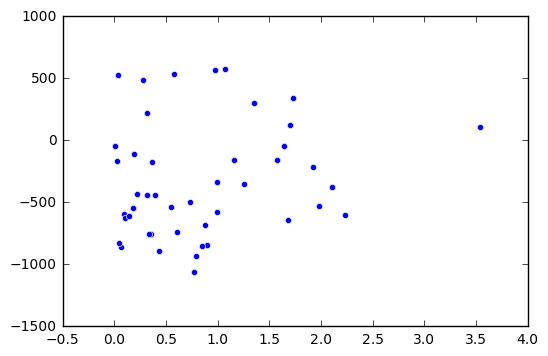

In [179]:
plt.scatter(deltas_tica.loc[(deltas_tica["tm6_tm3_dist"] > 12.0)][" 3p0g_lig"].values, deltas_tica.loc[(deltas_tica["tm6_tm3_dist"] > 12.0)]["tIC.1"].values)

In [ ]:
plt.scatter(df_agg

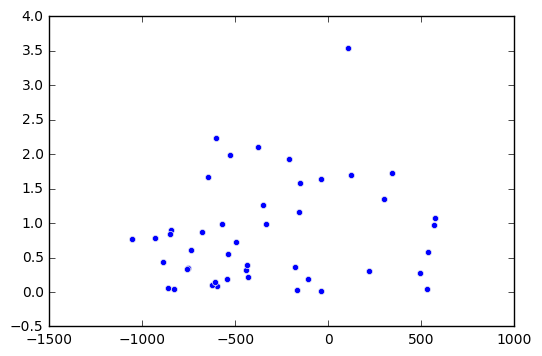

In [190]:
plt.scatter(deltas_tica.loc[(deltas_tica["tm6_tm3_dist"] > 12.0)]["tIC.1"].values, deltas_tica.loc[(deltas_tica["tm6_tm3_dist"] > 12.0)][" 3p0g_lig"].values)

In [285]:
agonist_states = deltas_tica.loc[(deltas_tica[biased_ligands].max(axis=1) < deltas_tica[non_bias_agonists].min(axis=1)) & (deltas_tica[non_biased_ligands].min(axis=1) > 1.0) & (deltas_tica["tm6_tm3_dist"] > 12.)]
agonist_states.sort(" r_epinephrine", ascending=False)

,isoetharine,r_isopreterenol,3p0g_lig,r_epinephrine,nebivolol,s-carvedilol,xamoterol,procaterol,tIC.1,tIC.2,tIC.3,tm6_tm3_dist,rmsd_npxxy_inactive,rmsd_npxxy_active,rmsd_connector_inactive,rmsd_connector_active
cluster62,2.352573,2.373701,1.924717,1.998863,0.528826,0.410477,1.070080,2.925784,-212.660540,659.895230,-167.491005,14.459442,1.056752,0.356988,1.563351,0.725105
cluster44,1.346407,1.730064,0.731424,1.851729,0.454010,0.349451,0.842959,1.253497,-494.451102,242.476838,-101.512880,13.648558,0.768528,0.592951,1.099214,1.002938
cluster39,1.523470,1.475444,1.258578,1.757012,0.569734,0.386222,0.868410,1.715558,-348.639104,337.188926,-107.947132,12.538080,0.586352,0.752953,0.848097,1.262639
cluster83,1.362222,1.496560,1.159027,1.519625,0.451449,0.645079,0.784670,1.609003,-159.980646,488.922919,-110.429884,12.718732,0.718892,0.652932,0.935480,1.075192
cluster59,1.060566,1.419611,0.994201,1.454037,0.921532,1.131982,0.993272,1.190149,-332.784644,161.781545,4.512933,13.285576,0.536252,0.805594,0.838691,1.194183


In [286]:
agonist_population = new_populations.loc[agonist_states.index].sum(axis=0)
agonist_ori = msm_cluster_eq_pops_df.loc[agonist_states.index].sum().values[0]
agonist_change = agonist_population.divide(agonist_ori)

#gprot_population = new_populations.loc[agonist_states.index].sum(axis=0)
#gprot_ori = msm_cluster_eq_pops_df.loc[agonist_states.index].sum().values[0]
#gprot_change = agonist_population.divide(agonist_ori)

biased_population = new_populations.loc[biased_states.index].sum(axis=0)
biased_ori = msm_cluster_eq_pops_df.loc[biased_states.index].sum().values[0]
biased_change = biased_population.divide(biased_ori)

biased_vs_agonist_state_change = biased_change.divide(agonist_change)

In [287]:
print(agonist_change)
print(biased_change) 
print(biased_vs_agonist_state_change)

 isoetharine        1.540001
 r_isopreterenol    1.731408
 3p0g_lig           1.210394
 r_epinephrine      1.730469
 nebivolol          0.599888
 s-carvedilol       0.595221
 xamoterol          0.926634
 procaterol         1.744847
dtype: float64
 isoetharine        1.216268
 r_isopreterenol    1.020577
 3p0g_lig           2.165464
 r_epinephrine      1.065143
 nebivolol          2.690099
 s-carvedilol       2.168303
 xamoterol          2.165515
 procaterol         0.748639
dtype: float64
 isoetharine        0.789783
 r_isopreterenol    0.589449
 3p0g_lig           1.789057
 r_epinephrine      0.615523
 nebivolol          4.484337
 s-carvedilol       3.642854
 xamoterol          2.336968
 procaterol         0.429057
dtype: float64


In [135]:
agonist_ligands

['3p0g_lig', 'procaterol', 'r_epinephrine', 'r_isopreterenol']

In [128]:
non_biased_ligands

[' isoetharine',
 ' r_isopreterenol',
 ' 3p0g_lig',
 ' r_epinephrine',
 ' procaterol ',
 'tIC.1',
 'tIC.2',
 'tIC.3',
 'tm6_tm3_dist',
 'rmsd_npxxy_inactive',
 'rmsd_npxxy_active',
 'rmsd_connector_inactive',
 'rmsd_connector_active']

In [121]:
print(biased_ligands)
print(non_biased_ligands)

[' nebivolol', ' s-carvedilol', ' xamoterol']
[' isoetharine', ' r_isopreterenol', ' 3p0g_lig', ' r_epinephrine', ' procaterol ', 'tIC.1', 'tIC.2', 'tIC.3', 'tm6_tm3_dist', 'rmsd_npxxy_inactive', 'rmsd_npxxy_active', 'rmsd_connector_inactive', 'rmsd_connector_active']


In [39]:
docking_tica_msm_ranked = pd.concat([aggregate_docking_msm.rank(axis=0, ascending=False), tica_cluster_averages_df, pnas_cluster_averages_df], axis=1).sort(" s-carvedilol", ascending=False)
docking_tica_msm_ranked.sort(" s-carvedilol", ascending=True).iloc[0:15]


,isoetharine,r_isopreterenol,3p0g_lig,r_epinephrine,nebivolol,s-carvedilol,xamoterol,procaterol,tIC.1,tIC.2,tIC.3,tm6_tm3_dist,rmsd_npxxy_inactive,rmsd_npxxy_active,rmsd_connector_inactive,rmsd_connector_active
cluster16,20,20,17,19.0,4,1,3,21,298.327555,-155.705678,-41.344052,8.098881,0.504904,0.989428,0.403042,1.487263
cluster80,21,54,19,77.0,1,2,2,50,847.962433,-84.929557,12.544195,8.162954,0.538104,0.956173,0.360018,1.498056
cluster43,60,64,10,42.0,3,3,5,53,343.215932,489.592359,427.928737,15.096400,0.753423,1.084534,1.843255,1.699191
cluster99,38,37,55,47.0,7,4,20,64,528.839801,-143.907087,36.367880,8.145755,0.580873,0.934381,0.452970,1.466344
cluster38,19,31,23,27.0,6,5,11,46,768.927627,-142.754306,-9.916779,7.860789,0.543306,0.942253,0.337654,1.478456
cluster69,53,51,27,48.0,12,6,37,57,575.414087,532.524626,398.287635,13.172779,0.735695,0.996973,1.648401,1.572560
cluster77,18,17,11,10.0,8,7,25,7,121.923243,723.868901,196.638431,13.736668,0.799407,0.738928,1.817884,1.406989
cluster2,51,32,29,28.0,18,8,24,36,-573.368234,569.151380,-159.014243,13.952347,0.456261,0.890838,0.754507,1.323048
cluster68,58,43,52,38.0,44,9,12,58,-585.807198,-608.999177,-65.263290,7.106790,0.446257,0.890274,0.392662,1.386929
cluster26,12,40,2,21.0,2,10,1,67,793.797922,-137.092495,391.098460,8.271168,0.594835,0.908593,0.580696,1.614681


In [95]:
r1 = docking_tica_msm_ranked.loc[(docking_tica_msm_ranked["tIC.1"] < 100) & (docking_tica_msm_ranked["tIC.2"] < -50.)].index
r2 = docking_tica_msm_ranked.loc[(docking_tica_msm_ranked["tIC.1"] > 100) & (docking_tica_msm_ranked["tIC.2"] < -50.)].index
r3 = docking_tica_msm_ranked.loc[(docking_tica_msm_ranked["tIC.1"] < 100) & (docking_tica_msm_ranked["tIC.2"] > -50.)].index
r4 = docking_tica_msm_ranked.loc[(docking_tica_msm_ranked["tIC.1"] > 100) & (docking_tica_msm_ranked["tIC.2"] > -50.)].index
r3_r4 = docking_tica_msm_ranked.loc[(docking_tica_msm_ranked["tIC.2"] > -50.)].index

In [107]:
docking_tica_msm_ranked.sort(" r_isopreterenol")
s3 = ["cluster62", "cluster61", "cluster36"]
s2 = ["cluster16", "cluster80", "cluster43", "cluster26"]
not_s2 = [cluster for cluster in msm_cluster_names if cluster not in s2]
tm6_out = docking_tica_msm.loc[(docking_tica_msm["tm6_tm3_dist"] > 12.)].index

In [108]:
s3 = 

SyntaxError: invalid syntax (<ipython-input-108-bf34425e99f9>, line 1)

In [109]:
r1_population = new_populations.loc[r1].sum(axis=0)
s2_population = new_populations.loc[s2].sum(axis=0)
not_s2_population = new_populations.loc[not_s2].sum(axis=0)
tm6_out_population = new_populations.loc[tm6_out].sum(axis=0)
s3_population = new_populations.loc[s3].sum(axis=0)
r2_population = new_populations.loc[r2].sum(axis=0)
r3_population = new_populations.loc[r3].sum(axis=0)
r3_r4_population = new_populations.loc[r3_r4].sum(axis=0)
r4_population = new_populations.loc[r4].sum(axis=0)

In [110]:
r1_ori = msm_cluster_eq_pops_df.loc[r1].sum().values[0]
r2_ori = msm_cluster_eq_pops_df.loc[r2].sum().values[0]
s2_ori = msm_cluster_eq_pops_df.loc[s2].sum().values[0]
not_s2_ori = msm_cluster_eq_pops_df.loc[not_s2].sum().values[0]
tm6_out_ori = msm_cluster_eq_pops_df.loc[tm6_out].sum().values[0]
s3_ori = msm_cluster_eq_pops_df.loc[s3].sum().values[0]
r3_ori = msm_cluster_eq_pops_df.loc[r3].sum().values[0]
r4_ori = msm_cluster_eq_pops_df.loc[r4].sum().values[0]
r3_r4_ori = msm_cluster_eq_pops_df.loc[r3_r4].sum().values[0]

In [111]:
r1_change = r1_population.divide(r1_ori)
r2_change = r2_population.divide(r2_ori)
s2_change = s2_population.divide(s2_ori)
not_s2_change = not_s2_population.divide(not_s2_ori)
tm6_out_change = tm6_out_population.divide(tm6_out_ori)
s3_change = s3_population.divide(s3_ori)
r3_change = r3_population.divide(r3_ori)
r4_change = r4_population.divide(r4_ori)
r3_r4_change = r3_r4_population.divide(r3_r4_ori)

print("r1")
print(r1_change)
print("r2")
print(r2_change)
print("r3")
print(r3_change)
print("r4")
print(r4_change)
print("r3_r4")
print(r3_r4_change)
print("r2/r3")
print(r2_change.divide(r3_change))
print("r2/r3_r4")
print(r2_change.divide(r3_r4_change))
print("s2")
print(s2_change)
print("not_s2")
print(not_s2_change)
print("s3")
print(s3_change)
print("s2/s3")
print(s2_change.divide(s3_change))
print("s2_change  / (not_s2_change)")
print(s2_change.divide(not_s2_change))

r1
 isoetharine        0.783033
 r_isopreterenol    0.875911
 3p0g_lig           0.595493
 r_epinephrine      0.931102
 nebivolol          0.510037
 s-carvedilol       0.743357
 xamoterol          0.807095
 procaterol         0.905499
dtype: float64
r2
 isoetharine        1.193953
 r_isopreterenol    0.984929
 3p0g_lig           1.064059
 r_epinephrine      1.025899
 nebivolol          1.809364
 s-carvedilol       1.682270
 xamoterol          1.305664
 procaterol         0.891090
dtype: float64
r3
 isoetharine        1.047316
 r_isopreterenol    1.073517
 3p0g_lig           0.856995
 r_epinephrine      1.104010
 nebivolol          0.600148
 s-carvedilol       0.805911
 xamoterol          0.887365
 procaterol         1.228035
dtype: float64
r4
 isoetharine        1.004016
 r_isopreterenol    1.057596
 3p0g_lig           1.433259
 r_epinephrine      0.951287
 nebivolol          1.166244
 s-carvedilol       0.877943
 xamoterol          1.036521
 procaterol         0.968765
dtype: float64


In [260]:
df = docking_tica_msm.loc[(docking_tica_msm["tIC.1"] < 0.) & (docking_tica_msm["tIC.3"] < 0.)]

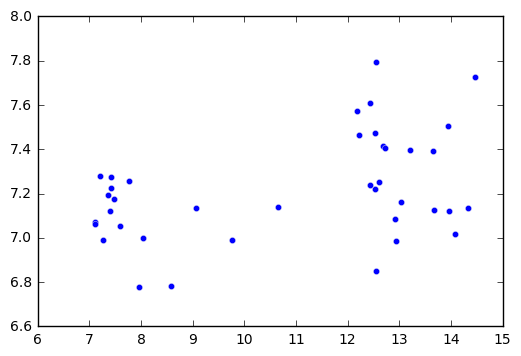

In [267]:
plt.scatter(df["tm6_tm3_dist"].values, df[" isoetharine"].values)

In [258]:
from scipy.stats import pearsonr
print(pearsonr(docking_tica_msm["tm6_tm3_dist"].values, docking_tica_msm[" r_epinephrine"].values))

(0.11246745757125538, 0.26524764370864734)


In [182]:
docking_tica_msm.rank(axis=0,method="min", ascending=False).sort(" s-carvedilol")

,isoetharine,r_isopreterenol,3p0g_lig,r_epinephrine,nebivolol,s-carvedilol,xamoterol,procaterol,tIC.1,tIC.2,tIC.3
cluster16,20,20,17,19,4,1,3,21,29,74,48
cluster80,21,54,19,77,1,2,2,50,1,64,37
cluster43,60,64,10,42,3,3,5,53,27,15,20
cluster99,38,37,55,47,7,4,20,64,22,73,35
cluster38,19,31,23,27,6,5,11,46,7,71,41
cluster69,53,51,27,48,12,6,37,57,18,13,23
cluster77,18,17,11,10,8,7,25,7,35,4,31
cluster2,51,32,29,28,18,8,24,36,74,11,91
cluster68,58,43,52,38,44,9,12,58,76,96,57
cluster26,12,40,2,21,2,10,1,67,4,69,24


In [308]:
population_deltas_tica_pnas = pd.concat([population_deltas, tica_cluster_averages_df, pnas_cluster_averages_df], axis=1)
population_deltas_tica_pnas.sort(" s-carvedilol", ascending=False)

,isoetharine,r_isopreterenol,3p0g_lig,r_epinephrine,nebivolol,s-carvedilol,xamoterol,procaterol,tIC.1,tIC.2,tIC.3,tm6_tm3_dist,rmsd_npxxy_inactive,rmsd_npxxy_active,rmsd_connector_inactive,rmsd_connector_active
cluster16,1.232318,1.252259,1.522004,1.245550,2.535744,3.428299,2.353619,1.299606,298.327555,-155.705678,-41.344052,8.098881,0.504904,0.989428,0.403042,1.487263
cluster80,1.232772,0.826946,1.391520,0.624552,3.936094,3.229841,2.406859,0.773959,847.962433,-84.929557,12.544195,8.162954,0.538104,0.956173,0.360018,1.498056
cluster43,0.768050,0.716640,1.726156,0.979656,2.600463,2.893885,1.969585,0.741261,343.215932,489.592359,427.928737,15.096400,0.753423,1.084534,1.843255,1.699191
cluster99,1.021306,0.984587,0.591878,0.922281,1.700074,2.790579,1.242931,0.613186,528.839801,-143.907087,36.367880,8.145755,0.580873,0.934381,0.452970,1.466344
cluster38,1.330607,1.152985,1.226420,1.162976,1.897541,2.481350,1.519973,0.843777,768.927627,-142.754306,-9.916779,7.860789,0.543306,0.942253,0.337654,1.478456
cluster69,0.831374,0.827845,1.071180,0.915231,1.569093,2.216145,0.928819,0.670350,575.414087,532.524626,398.287635,13.172779,0.735695,0.996973,1.648401,1.572560
cluster77,1.278656,1.328249,1.698265,1.469844,1.659859,1.963987,1.071293,2.009007,121.923243,723.868901,196.638431,13.736668,0.799407,0.738928,1.817884,1.406989
cluster2,0.852537,1.097659,0.992950,1.128032,1.362586,1.952210,1.112769,1.082882,-573.368234,569.151380,-159.014243,13.952347,0.456261,0.890838,0.754507,1.323048
cluster68,0.794539,0.961821,0.643108,1.053061,0.669118,1.901077,1.495319,0.673659,-585.807198,-608.999177,-65.263290,7.106790,0.446257,0.890274,0.392662,1.386929
cluster26,1.420511,0.982556,3.205327,1.244869,3.527561,1.864235,2.935097,0.598606,793.797922,-137.092495,391.098460,8.271168,0.594835,0.908593,0.580696,1.614681


In [307]:
population_deltas_tica_pnas["rmsd_npxxy_active"].values

array([ 0.35698783,  0.43160227,  0.59295088,  0.63030362,  0.63333797,
        0.65293187,  0.66224384,  0.67017162,  0.73826343,  0.73892808,
        0.74955833,  0.75290483,  0.75295299,  0.78759044,  0.78811908,
        0.79329103,  0.79843843,  0.80559367,  0.81084239,  0.82637632,
        0.82656091,  0.8328324 ,  0.84843314,  0.85063511,  0.85495132,
        0.85540825,  0.85763031,  0.85766172,  0.85895813,  0.86232501,
        0.86251152,  0.86426586,  0.86467093,  0.86565667,  0.86577374,
        0.86589438,  0.86691469,  0.86835039,  0.87056911,  0.87141472,
        0.87295121,  0.87480605,  0.87488991,  0.87489223,  0.87699902,
        0.87742651,  0.87914783,  0.88002205,  0.881428  ,  0.88458323,
        0.88725036,  0.88784051,  0.88837487,  0.88894027,  0.88918275,
        0.8896637 ,  0.89027405,  0.89083838,  0.89165175,  0.89276659,
        0.89389592,  0.89622891,  0.90318012,  0.90502119,  0.90627015,
        0.90643591,  0.90697461,  0.9076165 ,  0.90807325,  0.90

In [301]:
high_tIC2_low_tIC1 = population_deltas_tica_pnas.loc[(population_deltas_tica_pnas["tIC.1"] < 0.) & (population_deltas_tica_pnas["tIC.2"] > 0.)]
high_tIC2_low_tIC1.sort(" s-carvedilol", ascending=False).iloc[0:10]

,isoetharine,r_isopreterenol,3p0g_lig,r_epinephrine,nebivolol,s-carvedilol,xamoterol,procaterol,tIC.1,tIC.2,tIC.3,tm6_tm3_dist,rmsd_npxxy_inactive,rmsd_npxxy_active,rmsd_connector_inactive,rmsd_connector_active
cluster2,0.852537,1.097659,0.992950,1.128032,1.362586,1.952210,1.112769,1.082882,-573.368234,569.151380,-159.014243,13.952347,0.456261,0.890838,0.754507,1.323048
cluster12,0.518096,0.424734,0.362556,0.787197,1.476071,1.770853,0.551741,0.347772,-176.971711,225.319862,426.898254,12.663861,0.713618,0.670172,2.190558,1.774371
cluster94,1.405731,1.876251,1.675907,1.667353,0.706674,1.640593,1.367450,2.082818,-644.570245,455.884642,-175.798493,12.680894,0.445717,0.870569,0.479588,1.444026
cluster54,1.012971,0.968852,0.791069,1.152943,0.663009,1.291537,1.075761,1.216793,-930.864745,60.676379,-132.420867,12.537092,0.443572,0.864266,0.459767,1.407731
cluster24,0.332867,0.360850,0.189845,0.644038,0.535571,1.254189,0.463497,0.339082,-106.738522,761.986728,513.575626,13.283482,0.856763,0.630304,2.346961,1.548581
cluster59,1.060566,1.419611,0.994201,1.454037,0.921532,1.131982,0.993272,1.190149,-332.784644,161.781545,4.512933,13.285576,0.536252,0.805594,0.838691,1.194183
cluster98,0.854195,1.129516,0.873018,1.202517,0.491969,1.084267,1.041638,1.133037,-680.230596,186.368052,-106.423276,13.670673,0.578283,0.793291,0.762615,1.273547
cluster27,0.542712,0.640192,0.352830,0.829192,0.427876,1.038028,0.641852,0.739226,-753.283076,75.462395,-101.061203,12.542440,0.461659,0.889664,0.559422,1.386004
cluster89,0.252019,0.272477,0.182114,0.401892,0.652249,1.017059,0.428330,0.277180,-543.447699,676.215888,471.378630,13.114884,0.446686,0.865657,2.561983,1.789429
cluster8,0.913490,0.955904,0.767447,1.068437,0.381532,0.995362,0.901743,1.273813,-1058.032313,97.524387,-123.383999,13.022407,0.435752,0.850635,0.457036,1.523810


In [311]:
population_deltas_tica_pnas.loc[(population_deltas_tica_pnas["tm6_tm3_dist"] > 12.)].sort(" s-carvedilol", ascending=False)

,isoetharine,r_isopreterenol,3p0g_lig,r_epinephrine,nebivolol,s-carvedilol,xamoterol,procaterol,tIC.1,tIC.2,tIC.3,tm6_tm3_dist,rmsd_npxxy_inactive,rmsd_npxxy_active,rmsd_connector_inactive,rmsd_connector_active
cluster43,0.768050,0.716640,1.726156,0.979656,2.600463,2.893885,1.969585,0.741261,343.215932,489.592359,427.928737,15.096400,0.753423,1.084534,1.843255,1.699191
cluster69,0.831374,0.827845,1.071180,0.915231,1.569093,2.216145,0.928819,0.670350,575.414087,532.524626,398.287635,13.172779,0.735695,0.996973,1.648401,1.572560
cluster77,1.278656,1.328249,1.698265,1.469844,1.659859,1.963987,1.071293,2.009007,121.923243,723.868901,196.638431,13.736668,0.799407,0.738928,1.817884,1.406989
cluster2,0.852537,1.097659,0.992950,1.128032,1.362586,1.952210,1.112769,1.082882,-573.368234,569.151380,-159.014243,13.952347,0.456261,0.890838,0.754507,1.323048
cluster12,0.518096,0.424734,0.362556,0.787197,1.476071,1.770853,0.551741,0.347772,-176.971711,225.319862,426.898254,12.663861,0.713618,0.670172,2.190558,1.774371
cluster94,1.405731,1.876251,1.675907,1.667353,0.706674,1.640593,1.367450,2.082818,-644.570245,455.884642,-175.798493,12.680894,0.445717,0.870569,0.479588,1.444026
cluster97,1.502912,1.352727,0.900506,1.337431,0.804389,1.507679,1.487546,1.730774,-845.173003,-23.442572,-107.555631,12.221868,0.448232,0.865894,0.512939,1.400361
cluster29,1.413701,1.037073,0.978358,0.921914,1.242097,1.505756,0.885656,1.192522,565.733529,463.517202,-16.628684,12.369645,0.618264,0.884583,0.541440,1.392939
cluster13,0.628477,0.512369,0.311215,0.674318,0.542308,1.389833,0.391004,0.405774,218.602344,767.688438,687.996319,14.429488,0.701767,0.984883,2.405524,1.722553
cluster54,1.012971,0.968852,0.791069,1.152943,0.663009,1.291537,1.075761,1.216793,-930.864745,60.676379,-132.420867,12.537092,0.443572,0.864266,0.459767,1.407731


In [278]:
bias_agonist_averages = pd.concat([population_deltas[[" nebivolol", " s-carvedilol", " xamoterol"]].mean(axis=1), population_deltas[[" r_epinephrine", " r_isopreterenol", " 3p0g_lig"]].mean(axis=1)], axis=1)
bias_agonist_averages.columns = ["biased_ligands", "agonist_ligands"]
bias_agonist_averages.sort("biased_ligands", ascending=False).iloc[0:10]

,biased_ligands,agonist_ligands
cluster80,3.190931,0.947672
cluster26,2.775631,1.810917
cluster16,2.772554,1.339937
cluster43,2.487978,1.140817
cluster38,1.966288,1.180793
cluster99,1.911195,0.832916
cluster74,1.844567,0.738967
cluster9,1.620396,0.978438
cluster50,1.584631,0.753860
cluster69,1.571352,0.938085


In [291]:
import grids
reload(grids)
from grids import *
convert_maegz_files_to_pdb("%s/s-carvedilol" %docking_dir, ".maegz", worker_pool=dview)
convert_maegz_files_to_pdb("%s/xamoterol" %docking_dir, ".maegz", worker_pool=dview)
convert_maegz_files_to_pdb("%s/nebivolol" %docking_dir, ".maegz", worker_pool=dview)
convert_maegz_files_to_pdb("%s/r_epinephrine" %docking_dir, ".maegz", worker_pool=dview)
convert_maegz_files_to_pdb("%s/r_isopreterenol" %docking_dir, ".maegz", worker_pool=dview)
convert_maegz_files_to_pdb("%s/3p0g_lig" %docking_dir, ".maegz", worker_pool=dview)


In [290]:
len(rc.ids)

273

In [211]:
population_deltas.sort(" s-carvedilol", ascending=False).rank(ascending=False).iloc[0:10]

,isoetharine,r_isopreterenol,3p0g_lig,r_epinephrine,nebivolol,s-carvedilol,xamoterol,procaterol
cluster16,22,21,17,19,4,1,3,20
cluster80,21,55,18,75,1,2,2,49
cluster43,61,65,10,43,3,3,5,53
cluster99,39,38,55,48,7,4,21,64
cluster38,17,29,22,26,6,5,10,46
cluster69,54,54,27,51,12,6,39,61
cluster77,19,17,11,11,8,7,29,7
cluster2,52,32,30,28,18,8,24,36
cluster68,58,42,52,38,43,9,11,57
cluster26,10,40,2,20,2,10,1,66


In [190]:
new_populations.iloc[0:10]

,isoetharine,r_isopreterenol,3p0g_lig,r_epinephrine,nebivolol,s-carvedilol,xamoterol,procaterol
cluster0,0.023293,0.022449,0.018241,0.018158,0.034000,0.014304,0.022259,0.015292
cluster1,0.003234,0.004864,0.002282,0.005375,0.004785,0.008104,0.006692,0.004065
cluster2,0.006286,0.008093,0.007321,0.008317,0.010046,0.014393,0.008204,0.007984
cluster3,0.000949,0.000503,0.000091,0.000965,0.000523,0.000976,0.001060,0.000241
cluster4,0.005586,0.003895,0.005313,0.003157,0.001609,0.001989,0.003283,0.004464
cluster5,0.009288,0.011958,0.009529,0.009316,0.004689,0.003491,0.008338,0.010194
cluster6,0.021841,0.018346,0.016023,0.017788,0.013972,0.011609,0.011631,0.019328
cluster7,0.036518,0.049561,0.029203,0.046024,0.017370,0.014776,0.022262,0.042876
cluster8,0.006114,0.006398,0.005137,0.007152,0.002554,0.006662,0.006036,0.008526
cluster9,0.006288,0.005485,0.008629,0.008287,0.010601,0.011311,0.015186,0.002571


In [191]:
new_populations.sum()

 isoetharine        1
 r_isopreterenol    1
 3p0g_lig           1
 r_epinephrine      1
 nebivolol          1
 s-carvedilol       1
 xamoterol          1
 procaterol         1
dtype: float64

In [195]:
population_iso = new_populations.div(new_populations[" r_isopreterenol"], axis='index')
population_iso.sort(" s-carvedilol", axis=0, ascending=False).iloc[0:10]

,isoetharine,r_isopreterenol,3p0g_lig,r_epinephrine,nebivolol,s-carvedilol,xamoterol,procaterol
cluster76,1.170325,1,0.366074,1.436144,3.744188,6.170514,2.595221,0.812569
cluster92,1.342497,1,0.441618,1.937622,2.769298,5.353520,1.954139,0.772403
cluster42,1.325710,1,0.485656,1.569298,1.884266,4.513692,1.947095,1.152322
cluster12,1.219814,1,0.853609,1.853391,3.475287,4.169326,1.299028,0.818800
cluster41,1.218121,1,0.398484,1.774053,3.511677,4.149107,2.851164,0.652918
cluster43,1.071738,1,2.408680,1.367013,3.628689,4.038131,2.748362,1.034356
cluster20,1.389969,1,0.234980,2.153932,4.443926,4.022011,6.701547,0.599963
cluster80,1.490753,1,1.682721,0.755251,4.759796,3.905746,2.910539,0.935924
cluster48,1.649735,1,0.408912,1.469068,3.156735,3.879794,1.785452,0.604782
cluster15,1.222969,1,0.705449,1.969858,1.983517,3.848880,2.503455,0.697057


In [209]:
population_iso.loc[(population_iso[" isoetharine"] < 1.0) & (population_iso[" 3p0g_lig"] < 1.0) & (population_iso[" r_epinephrine"] < 1.0)]

,isoetharine,r_isopreterenol,3p0g_lig,r_epinephrine,nebivolol,s-carvedilol,xamoterol,procaterol
cluster5,0.776708,1,0.796895,0.779074,0.392089,0.291921,0.697254,0.852453
cluster7,0.736840,1,0.589240,0.928636,0.350476,0.298132,0.449182,0.865120
cluster14,0.701332,1,0.700333,0.907672,0.448635,0.609049,0.470967,0.989034
cluster17,0.866998,1,0.247853,0.972999,0.875936,1.028857,0.404814,0.802877
cluster32,0.782948,1,0.903219,0.798844,1.593795,0.620426,1.360609,0.733646
cluster47,0.744223,1,0.524142,0.931493,0.396745,0.600086,0.711331,0.756318
cluster62,0.991099,1,0.810851,0.842087,0.222786,0.172927,0.450806,1.232584
cluster67,0.773586,1,0.673733,0.910855,0.498013,1.282035,0.747520,0.729871
cluster71,0.972014,1,0.464583,0.836259,0.617485,0.890479,0.998423,0.759636
cluster72,0.867986,1,0.578986,0.921006,0.361742,0.249346,0.470640,0.927822


In [196]:
population_iso.sum()

 isoetharine        110.789519
 r_isopreterenol    100.000000
 3p0g_lig            82.292282
 r_epinephrine      120.080654
 nebivolol          130.874248
 s-carvedilol       159.213096
 xamoterol          131.575778
 procaterol          96.123718
dtype: float64

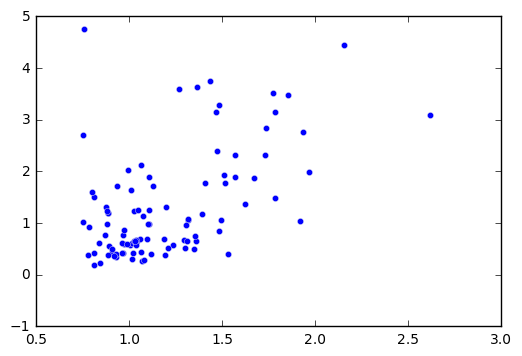

In [202]:
plt.scatter(population_iso[" r_epinephrine"].values, population_iso[" nebivolol"].values)

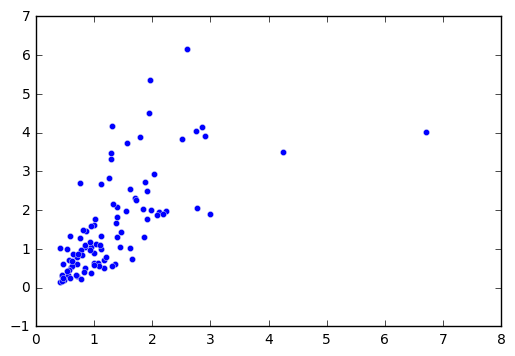

In [233]:
plt.scatter(population_iso[" xamoterol"].values, population_iso[" s-carvedilol"].values)

loading "/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/clusterer_tICs_1_2_3_100clusters_25samples.h5"...
loading "/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/phi_psi_chi2_allprot_projected.h5"...


,tIC.1,tIC.2,tIC.3
cluster0,674.128220,-28.152244,-22.450247
cluster1,-501.478697,-364.087591,-118.766939
cluster2,-573.368234,569.151380,-159.014243
cluster3,-540.443346,-431.528860,774.028194
cluster4,299.819550,590.250108,-86.715218
cluster5,-41.800904,603.737790,-65.628949
cluster6,140.743640,-219.394936,-76.138061
cluster7,-553.301111,-594.405663,-143.372952
cluster8,-1058.032313,97.524387,-123.383999
cluster9,597.693228,-143.495035,308.665294


In [166]:
population_iso_tica = pd.concat([population_iso, tica_cluster_averages_df], axis=1)
population_iso_tica.iloc[0:10]

,isoetharine,r_isopreterenol,3p0g_lig,r_epinephrine,nebivolol,s-carvedilol,xamoterol,procaterol,tIC.1,tIC.2,tIC.3
cluster0,1.198235,1,0.367556,1.919825,0.890650,2.662384,1.574083,0.991623,674.128220,-28.152244,-22.450247
cluster1,1.869730,1,0.636643,1.405120,1.371328,1.018219,1.134447,0.808317,-501.478697,-364.087591,-118.766939
cluster2,1.600732,1,0.330148,1.511027,1.086665,0.953822,1.539532,0.684682,-573.368234,569.151380,-159.014243
cluster3,0.658360,1,1.652053,0.809439,1.296006,0.873954,0.739938,1.407775,-540.443346,-431.528860,774.028194
cluster4,0.866865,1,0.218957,1.915776,3.264521,3.322515,1.851776,0.589311,299.819550,590.250108,-86.715218
cluster5,1.600687,1,0.374773,1.993185,3.440392,5.811144,2.238388,0.792377,-41.800904,603.737790,-65.628949
cluster6,1.044303,1,0.341946,1.601569,1.771269,2.680937,2.461806,0.641130,140.743640,-219.394936,-76.138061
cluster7,1.687297,1,0.506847,1.672171,3.848871,5.690066,3.474597,0.780776,-553.301111,-594.405663,-143.372952
cluster8,1.300993,1,0.371993,1.389285,3.379676,1.629145,1.654466,0.506887,-1058.032313,97.524387,-123.383999
cluster9,1.084509,1,0.189845,1.027837,0.697988,0.822606,0.563725,1.440801,597.693228,-143.495035,308.665294


In [168]:
population_iso_tica.sort(" nebivolol", axis=0, ascending=False).iloc[0:10]

,isoetharine,r_isopreterenol,3p0g_lig,r_epinephrine,nebivolol,s-carvedilol,xamoterol,procaterol,tIC.1,tIC.2,tIC.3
cluster21,1.186642,1,0.246052,1.913223,7.407156,5.252593,2.837183,0.294601,-601.813690,333.272348,-168.735170
cluster62,1.254432,1,0.368322,1.844035,6.054872,9.809866,3.462072,0.548007,-212.660540,659.895230,-167.491005
cluster44,1.597534,1,0.706419,1.450811,5.140309,8.398518,3.203183,0.932269,-494.451102,242.476838,-101.512880
cluster60,1.482596,1,0.309474,1.439251,4.574267,11.565832,3.809425,0.459568,116.271286,23.097325,-111.712249
cluster83,1.365874,1,0.385629,1.529268,4.471750,3.935568,2.976689,0.628260,-159.980646,488.922919,-110.429884
cluster7,1.687297,1,0.506847,1.672171,3.848871,5.690066,3.474597,0.780776,-553.301111,-594.405663,-143.372952
cluster72,1.432358,1,0.515823,1.686023,3.729003,6.803358,3.316174,0.728011,-458.639998,-517.935778,-119.846760
cluster94,1.659408,1,0.334357,1.747389,3.581493,1.940066,2.141440,0.608474,-644.570245,455.884642,-175.798493
cluster39,1.204074,1,0.350116,1.303989,3.493357,6.480549,2.651699,0.580925,-348.639104,337.188926,-107.947132
cluster5,1.600687,1,0.374773,1.993185,3.440392,5.811144,2.238388,0.792377,-41.800904,603.737790,-65.628949


In [135]:
population_deltas_sorted = population_deltas.sort([" s-carvedilol"], ascending=False)

In [136]:
population_deltas_sorted.iloc[0:10]

,isoetharine,r_isopreterenol,3p0g_lig,r_epinephrine,nebivolol,s-carvedilol,xamoterol,procaterol
cluster35,49.743606,46.039711,86.416612,41.118594,21.826946,42.656115,51.424853,70.857840
cluster60,3.339890,2.252731,0.697163,3.242246,10.304596,26.054714,8.581613,1.035284
cluster63,9.048826,10.664538,39.643736,10.800307,36.108821,17.620492,10.252702,13.317348
cluster52,16.385193,13.780443,5.791379,16.216672,17.271025,14.750923,22.844921,9.938832
cluster31,22.913175,27.740773,12.106742,16.442931,12.063223,13.421683,10.185757,18.393833
cluster13,21.698478,21.407758,10.525971,25.258979,27.283529,13.388072,43.782393,18.258795
cluster19,7.494015,5.864851,7.686231,6.104950,7.483922,9.977830,8.251999,4.872024
cluster91,15.048998,12.912344,13.854875,12.776913,7.482974,8.789628,10.517026,17.791418
cluster45,10.147076,14.831075,10.645934,12.912305,6.341854,8.557259,11.406724,15.290888
cluster22,4.815433,3.770046,2.265678,4.491729,9.689143,8.076414,4.912933,1.566018


In [144]:
population_deltas_iso = population_deltas.div(population_deltas[" r_isopreterenol"], axis='index')

In [148]:
population_deltas_iso.sort(" 3p0g_lig", ascending=False).iloc[0:100]

,isoetharine,r_isopreterenol,3p0g_lig,r_epinephrine,nebivolol,s-carvedilol,xamoterol,procaterol
cluster63,0.848497,1,3.717342,1.012731,3.385878,1.652251,0.961383,1.248751
cluster35,1.080450,1,1.877002,0.893111,0.474090,0.926507,1.116967,1.539059
cluster10,0.609666,1,1.749862,1.103803,0.759700,0.858368,0.698010,1.228964
cluster3,0.658360,1,1.652053,0.809439,1.296006,0.873954,0.739938,1.407775
cluster19,1.277784,1,1.310559,1.040939,1.276063,1.701293,1.407026,0.830716
cluster20,0.894456,1,1.270978,0.720932,0.303547,0.421777,0.232890,1.125843
cluster17,1.433990,1,1.204968,1.595929,1.539996,1.648812,3.855414,0.841305
cluster91,1.165474,1,1.072995,0.989512,0.579521,0.680715,0.814494,1.377861
cluster73,0.770379,1,1.043367,1.189409,1.402767,0.891713,0.716158,0.794427
cluster66,1.241171,1,0.909957,1.480248,1.079695,1.713368,2.900125,0.750531


In [137]:
aggregate_docking_msm.rank().sort(" nebivolol", ascending=True, axis=0)

,isoetharine,r_isopreterenol,3p0g_lig,r_epinephrine,nebivolol,s-carvedilol,xamoterol,procaterol
cluster63,5.0,6,1,3.0,1,1,2,4
cluster3,8.0,5,4,6.0,2,4,5,3
cluster73,12.0,8,8,7.0,3,8,8,9
cluster19,7.0,12,7,10.0,4,3,4,12
cluster35,1.0,2,2,1.0,5,2,1,1
cluster91,3.0,7,5,5.0,6,9,6,5
cluster45,6.0,3,6,4.0,7,7,3,6
cluster20,2.0,1,3,2.0,8,6,12,2
cluster31,4.0,4,11,9.0,9,11,11,7
cluster42,10.0,10,12,8.0,10,35,7,16


In [138]:
aggregate_docking_msm.sort(" nebivolol", ascending=False, axis=0)

,isoetharine,r_isopreterenol,3p0g_lig,r_epinephrine,nebivolol,s-carvedilol,xamoterol,procaterol
cluster80,7.336800,7.245200,10.142000,6.952400,10.236000,9.725600,8.698400,8.530000
cluster26,7.416800,7.343600,10.637600,7.361200,10.165200,9.390800,8.812400,8.370800
cluster43,7.064000,7.170400,10.282400,7.233600,9.998400,9.670800,8.589200,8.515200
cluster16,7.340400,7.498000,10.199600,7.370400,9.976000,9.765200,8.688800,8.844800
cluster74,7.298000,7.252400,9.790000,6.955200,9.904800,9.330000,8.472000,8.280800
cluster38,7.375600,7.437600,10.059200,7.318400,9.791200,9.560400,8.415600,8.574800
cluster99,7.232800,7.358800,9.638000,7.195200,9.741200,9.646800,8.310800,8.399200
cluster77,7.376800,7.547600,10.279600,7.484000,9.736000,9.445200,8.230800,9.120400
cluster50,7.151600,7.202800,9.698400,7.114800,9.709600,9.369600,8.336000,8.442800
cluster0,7.277917,7.403750,9.863750,7.152083,9.707500,8.796250,8.210833,8.497917


In [139]:
aggregate_docking_norm = (aggregate_docking_msm - aggregate_docking_msm.mean()) / (aggregate_docking_msm.max() - aggregate_docking_msm.min())

In [141]:
aggregate_docking_norm.sort(" nebivolol", axis=0, ascending=False)

,isoetharine,r_isopreterenol,3p0g_lig,r_epinephrine,nebivolol,s-carvedilol,xamoterol,procaterol
cluster80,0.157265,0.062045,0.178592,-0.064556,0.379948,0.395875,0.338169,0.051573
cluster26,0.193924,0.105277,0.310367,0.166350,0.355187,0.244539,0.391871,-0.000704
cluster43,0.032259,0.029181,0.215923,0.094277,0.296852,0.371105,0.286728,0.046713
cluster16,0.158915,0.173113,0.193908,0.171547,0.289018,0.413776,0.333647,0.154945
cluster74,0.139486,0.065208,0.084999,-0.062974,0.264117,0.217056,0.231518,-0.030257
cluster38,0.175045,0.146576,0.156577,0.142175,0.224387,0.321201,0.204950,0.066285
cluster99,0.109609,0.111955,0.044584,0.072587,0.206901,0.360256,0.155581,0.008622
cluster77,0.175595,0.194904,0.215179,0.235713,0.205082,0.269129,0.117896,0.245445
cluster50,0.072400,0.043416,0.060644,0.027174,0.195849,0.234956,0.167452,0.022939
cluster0,0.130283,0.131704,0.104609,0.048233,0.195115,-0.024211,0.108490,0.041038


In [ ]:
graph_file = "%s/msm_tICs_1_2_3_n_clusters%dlag_time%d_graph.h5" % (tica_dir, n_clusters, lag_time)
graph = construct_graph(msm_model_dir, clusterer_tICs_1_2_3_filename n_clusters, 10, lag_time, graph_file)


In [123]:
docking_multiple_ligands = "%s/all_docking_scores.csv" % docking_dir
aggregate_docking = "%s/aggregate_docking.csv" % docking_dir

#analyze_docking_results_multiple(docking_dir, precision = "SP", ligands = biased_ligands + agonist_ligands, summary = docking_multiple_ligands, redo = True)
#compute_cluster_averages(None, csv_filename=docking_multiple_ligands, save_csv=aggregate_docking)


In [128]:
df_agg = pd.read_csv(aggregate_docking, index_col=0)
aggs = df_agg.sort([' nebivolol'], ascending=[0])
aggs.iloc[0:10]
ranked = aggs.rank(axis=0, method='average', ascending=False)

In [125]:
aggs.iloc[0:10]

,isoetharine,nebivolol,s-carvedilol,xamoterol
cluster80,7.336800,10.2360,9.72560,8.698400
cluster26,7.416800,10.1652,9.39080,8.812400
cluster43,7.064000,9.9984,9.67080,8.589200
cluster16,7.340400,9.9760,9.76520,8.688800
cluster74,7.298000,9.9048,9.33000,8.472000
cluster38,7.375600,9.7912,9.56040,8.415600
cluster99,7.232800,9.7412,9.64680,8.310800
cluster77,7.376800,9.7360,9.44520,8.230800
cluster50,7.151600,9.7096,9.36960,8.336000
cluster0,7.277917,9.7075,8.79625,8.210833


In [129]:
ranked.iloc[0:10]

,isoetharine,nebivolol,s-carvedilol,xamoterol
cluster80,21,1,2,2
cluster26,12,2,11,1
cluster43,60,3,3,5
cluster16,20,4,1,3
cluster74,26,5,13,8
cluster38,19,6,5,11
cluster99,38,7,4,20
cluster77,18,8,7,25
cluster50,46,9,12,17
cluster0,27,10,53,30


In [17]:
dock_ligands_and_receptors(grid_dir, docking_dir, inverse_agonist_dir, precision = precision, ext = "-out.maegz", chosen_ligands = inverse_ligands, chosen_receptors = chosen_receptors, parallel = None, grid_ext = ".grd", worker_pool=dview)

ligands
['/home/enf/b2ar_analysis/b2ar_inverse_agonists/s-atenolol-out.maegz', '/home/enf/b2ar_analysis/b2ar_inverse_agonists/s-carazolol-out.maegz']
Written all docking job input files
MAPPING OVER WORKER POOL
Done docking.
Written all docking job input files
MAPPING OVER WORKER POOL
Done docking.


In [116]:
msm_tica_clusters_averages = tica_clusters_averages()

array([[  6.74128220e+02,  -2.81522440e+01,  -2.24502469e+01, ...,
          2.20253375e+00,   1.52564573e+01,   2.02755052e+00],
       [ -5.01478697e+02,  -3.64087591e+02,  -1.18766939e+02, ...,
          3.51063116e+00,   1.45777687e-01,  -7.72877549e-01],
       [ -5.73368234e+02,   5.69151380e+02,  -1.59014243e+02, ...,
         -3.28841560e+01,  -6.06932019e+00,   1.75821874e+00],
       ..., 
       [ -8.45173003e+02,  -2.34425722e+01,  -1.07555631e+02, ...,
         -2.39849552e+00,  -1.13937186e+01,   1.18867069e+01],
       [ -6.80230596e+02,   1.86368052e+02,  -1.06423276e+02, ...,
         -1.26359401e+01,   4.47673461e+00,   5.81232172e+00],
       [  5.28839801e+02,  -1.43907087e+02,   3.63678799e+01, ...,
         -1.24553887e+00,   7.26574496e-01,  -2.96018142e+01]])

In [96]:
n_clusters = 25
n_samples=100

clusterer_tICs_1_2_filename = "%s/clusterer_tICs_1_2_%dclusters_%dsamples.h5" %(tica_dir, n_clusters, n_samples)
clusterer_tICs_1_2_map_file = "%s/clusterer_tICs_1_2_%dclusters_%dsamples_map.json" %(tica_dir, n_clusters, n_samples)
tics_to_cluster = [0, 1]


#cluster_minikmeans(tica_dir, projected_features_dir, traj_dir, n_clusters=n_clusters, clusterer_dir=clusterer_tICs_1_2_filename, tICs=tics_to_cluster)
#clusterer_tICs_1_2 = verboseload(clusterer_tICs_1_2_filename)
#clusterer_tICs_1_2_map = make_clusters_map(clusterer_tICs_1_2)
samples_dir = "%s/clusterer_tICs_1_2_%dclusters_%dsamples_samples" %(tica_dir, n_clusters, n_samples)
if not os.path.exists(samples_dir): os.makedirs(samples_dir)

#import custom_clusterer
#reload(custom_clusterer)
#from custom_clusterer import *
#sample_clusters(clusterer_tICs_1_2_filename, projected_features_dir, traj_dir, traj_ext, save_dir=samples_dir, n_samples=n_samples, method = sampling_method, clusters_map_file = clusterer_tICs_1_2_map_file, tICs=[0, 1], worker_pool=None)



In [97]:
len(rc.ids)

NameError: name 'rc' is not defined

In [99]:
indices = [0,n_clusters]
chosen_receptors = []
for i in range(indices[0], indices[1]):
  for j in range(0, n_samples):
    chosen_receptors.append("cluster%d_sample%d" %(i, j))

biased_ligands = get_ligands(biased_agonist_dir)
print("biased_ligands")
print(biased_ligands)
reimaged_dir = samples_dir
mae_dir = reimaged_dir
#remove_ter(reimaged_dir)
#reorder(reimaged_dir)

inverse_ligands = get_ligands(inverse_agonist_dir)
agonist_ligands = get_ligands(agonist_dir)

agonist_ligands = [a for a in agonist_ligands if "TA" not in a and "ta" not in a]
print(agonist_ligands)

grid_dir =  "%s/clusterer_tICs_1_2_%dclusters_%dsamples_grids" %(tica_dir, n_clusters, n_samples)
docking_dir =  "%s/clusterer_tICs_1_2_%dclusters_%dsamples_docking" %(tica_dir, n_clusters, n_samples)

#pprep(mae_dir, ref = active_ref_dir, chosen_receptors = chosen_receptors, worker_pool=dview)
#generate_grids(mae_dir, grid_center, grid_dir, remove_lig = "BIA", chosen_receptors = chosen_receptors, worker_pool=dview)
#unzip_receptors(grid_dir, chosen_receptors, worker_pool=dview)

#dock_ligands_and_receptors(grid_dir, docking_dir,  biased_agonist_dir, precision = precision, ext = "-out.maegz", chosen_ligands = biased_ligands, chosen_receptors = chosen_receptors, parallel = None, grid_ext = ".grd", worker_pool=dview)
#dock_ligands_and_receptors(grid_dir, docking_dir, agonist_dir, precision = precision, ext = "-out.maegz", chosen_ligands = agonist_ligands, chosen_receptors = chosen_receptors, parallel = None, grid_ext = ".grd", worker_pool=dview)

#dock_ligands_and_receptors(grid_dir, docking_dir, agonist_dir, precision = precision, ext = "-out.maegz", chosen_ligands = agonist_ligands, chosen_receptors = chosen_receptors, parallel = None, grid_ext = ".grd", worker_pool=dview)



biased_ligands
['', '', 'isoetharine', 'isoetharine_prepped', 'nebivolol', 's-carvedilol', 's-carvedilol_prepped', 'xamoterol']
['3p0g_lig', 'procaterol', 'r_epinephrine', 'r_isopreterenol']


In [100]:
docking_multiple_ligands = "%s/all_docking_scores.csv" % docking_dir
aggregate_docking = "%s/aggregate_docking.csv" % docking_dir

analyze_docking_results_multiple(docking_dir, precision = "SP", ligands = biased_ligands, summary = docking_multiple_ligands, redo = True)
compute_cluster_averages(None, csv_filename=docking_multiple_ligands, save_csv=aggregate_docking)

df_agg = pd.read_csv(aggregate_docking, index_col=0)
aggs = df_agg.sort([' nebivolol'], ascending=[0])
aggs.iloc[0:10]
ranked = aggs.rank(axis=0, method='average', ascending=False)



Analyzing docking results
/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/clusterer_tICs_1_2_25clusters_100samples_docking
['', '', 'isoetharine', 'isoetharine_prepped', 'nebivolol', 's-carvedilol', 's-carvedilol_prepped', 'xamoterol']
/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/clusterer_tICs_1_2_25clusters_100samples_docking/xamoterol
/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/clusterer_tICs_1_2_25clusters_100samples_docking/nebivolol
/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/clusterer_tICs_1_2_25clusters_100samples_docking/3p0g_lig
/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regulariz

In [111]:
aggs.sort(' nebivolol', ascending=False)

,xamoterol,nebivolol,isoetharine,s-carvedilol
cluster10,8.233646,9.669271,7.155729,8.989479
cluster19,8.346000,9.540300,7.423100,9.099300
cluster1,8.179596,9.537374,7.304949,9.161919
cluster5,8.120900,9.517300,7.342500,9.108200
cluster16,7.960505,9.477778,7.147980,9.073434
cluster0,8.274242,9.417273,7.361414,9.109394
cluster22,8.140505,9.330707,7.424343,8.845051
cluster3,8.016000,9.312300,7.090300,8.816000
cluster15,8.021313,9.276364,7.161818,8.755758
cluster13,8.097500,9.258542,7.314375,8.862604


In [101]:
ranked

,xamoterol,nebivolol,isoetharine,s-carvedilol
cluster10,3,1,10,8
cluster19,1,2,3,4
cluster1,5,3,7,1
cluster5,9,4,5,3
cluster16,19,5,11,5
cluster0,2,6,4,2
cluster22,8,7,2,12
cluster3,17,8,15,15
cluster15,16,9,8,18
cluster13,11,10,6,10


In [ ]:
plot_all_tics_and_clusters(tica_dir, transformed_data_dir, clusterer_dir, lag_time, tic_range=None, main="", label = "dot", active_cluster_ids = [], intermediate_cluster_ids = [], inactive_cluster_ids = [], inactive_subsample=5, intermediate_subsample=5, custom_cluster_centers=None, concatenate=True,)


In [ ]:
graph_file = "%s/msm_lag_time%d_graph.graphml" % (tica_dir, lag_time)
construct_graph(msm_model_dir, clusterer_dir, n_clusters, 5, 5, graph_file, inactive = None, active = None, pnas_clusters_averages = None, tica_clusters_averages = None, docking=None, macrostate = None)


In [ ]:
from imp import reload
import custom_msm
reload(custom_msm)
from custom_msm import *
msm_file = msm_model_dir
sampled_frames_file = "%s/msm100_frames.h5" %tica_dir
msm_trajectory_filename = "%s/msm100_1000frames" %tica_dir
make_msm_trajectory(msm_file, projected_features_dir, traj_dir, sampled_frames_file, clusterer_dir, msm_trajectory_filename, 
                    n_clusters, start_cluster=22, n_steps=1000)

In [ ]:
mytraj = md.load("/home/amir/Post_Process/GPCR/MOR/LIG_path/BU_path/h5_trajectories/rep_1.h5")

In [ ]:
dir(mytraj)

In [ ]:
del mytraj

In [ ]:
subset = crystal_structure.atom_slice(range(0,400))
subset.xyz
print(subset.xyz)
distances = md.compute_contacts(subset)
print(distances)


In [ ]:
distances0 = distances[0]

In [ ]:
distances0 = np.nan_to_num(distances0)

In [ ]:
distances0

In [ ]:
np.where(distances0 > 0.0)

In [97]:
from msmbuilder.lumping.pcca_plus import PCCAPlus
n_macrostates = 50
lumper = PCCAPlus(n_macrostates)
msm_obj = verboseload(msm_model_dir)
lumper = lumper.from_msm(msm=msm_obj, n_macrostates=n_macrostates)


loading "/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/msm_lag_time10.h5"...


In [109]:
for cluster in inactive_clusters.index.values:
    if cluster in msm_obj.mapping_.keys():
        microstate = msm_obj.mapping_[cluster]
        macrostate = lumper.microstate_mapping_[microstate]
        if macrostate == 8: print(macrostate)